In [344]:
import pandas as pd
from datetime import datetime
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sps
%matplotlib inline

In [345]:
import warnings
warnings.filterwarnings("ignore")

Скачаем данные из файла и посмотрим на то, как они выглядят.

In [346]:
data = pd.read_csv('electricity.csv', header=0, sep=',')

In [347]:
data.head(5)

Id  Consumption  Temperature  Time  DailySeasonality  WeeklySeasonality
0   0  3853.475392        20.90     0                 0                 48
1   1  3683.014105        20.70     1                 1                 49
2   2  3912.324031        20.50     2                 2                 50
3   3  3783.881181        20.05     3                 3                 51
4   4  3554.257244        19.60     4                 4                 52

In [348]:
data.index = pd.date_range('1/10/2000', periods=5520, freq='30min')

In [349]:
data.head(5)

Id  Consumption  Temperature  Time  DailySeasonality  \
2000-01-10 00:00:00   0  3853.475392        20.90     0                 0   
2000-01-10 00:30:00   1  3683.014105        20.70     1                 1   
2000-01-10 01:00:00   2  3912.324031        20.50     2                 2   
2000-01-10 01:30:00   3  3783.881181        20.05     3                 3   
2000-01-10 02:00:00   4  3554.257244        19.60     4                 4   

                     WeeklySeasonality  
2000-01-10 00:00:00                 48  
2000-01-10 00:30:00                 49  
2000-01-10 01:00:00                 50  
2000-01-10 01:30:00                 51  
2000-01-10 02:00:00                 52

Проверим, есть ли в нашем датафрейме пропущенные данные.

In [350]:
data.isnull().values.any()

False

Нет, хорошо.

Сразу же заметим, что похоже, что столбец Id дословно повторяет столбец Time. Так ли это?

In [351]:
print((data['Id'] == data['Time']).all())

True


Да. Тогда удалим этот столбец.

In [352]:
data.drop('Id', axis=1, inplace=True)

Усредним по часам, чтоб наша модель стала более устойчивой к выбросам, так как исходный ряд может содержать значительную ошибку

In [353]:
data = data.resample('H').mean()

In [354]:
data.head(5)

Consumption  Temperature  Time  DailySeasonality  \
2000-01-10 00:00:00  3768.244749       20.800   0.5               0.5   
2000-01-10 01:00:00  3848.102606       20.275   2.5               2.5   
2000-01-10 02:00:00  3458.250314       19.400   4.5               4.5   
2000-01-10 03:00:00  3213.982725       18.625   6.5               6.5   
2000-01-10 04:00:00  3259.637500       18.050   8.5               8.5   

                     WeeklySeasonality  
2000-01-10 00:00:00               48.5  
2000-01-10 01:00:00               50.5  
2000-01-10 02:00:00               52.5  
2000-01-10 03:00:00               54.5  
2000-01-10 04:00:00               56.5

Нарисуем графики зависимости спроса на электричество и температуры от времени. <br>

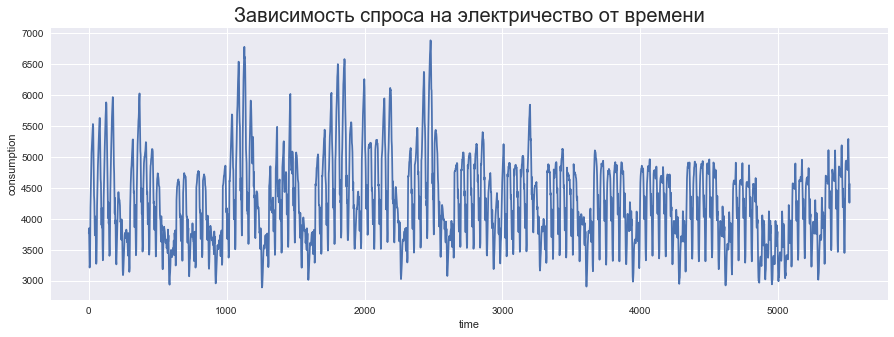

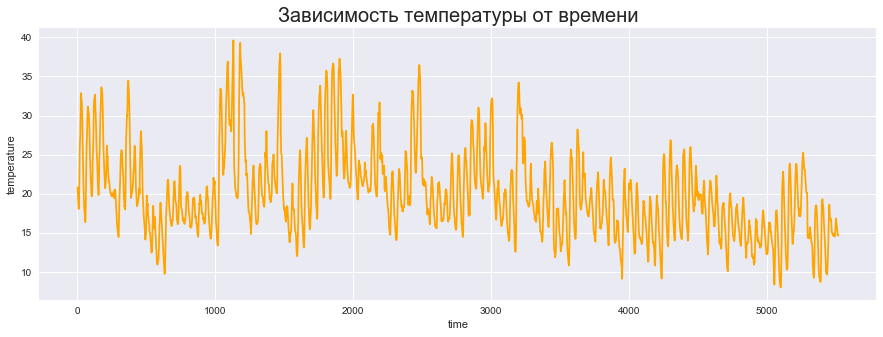

In [355]:
plt.figure(figsize=(15, 5))
plt.plot(data['Time'], data['Consumption'])
plt.xlabel('time')
plt.ylabel('consumption')
plt.title('Зависимость спроса на электричество от времени', fontsize=20)
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(data['Time'], data['Temperature'], c='orange')
plt.title('Зависимость температуры от времени',  fontsize=20)
plt.xlabel('time')
plt.ylabel('temperature')
plt.show()

По графикам можно понять, что в зависимостях присутствует некая сезонность. <br>


Сначала посмотрим визуально на попарные зависимости признаков

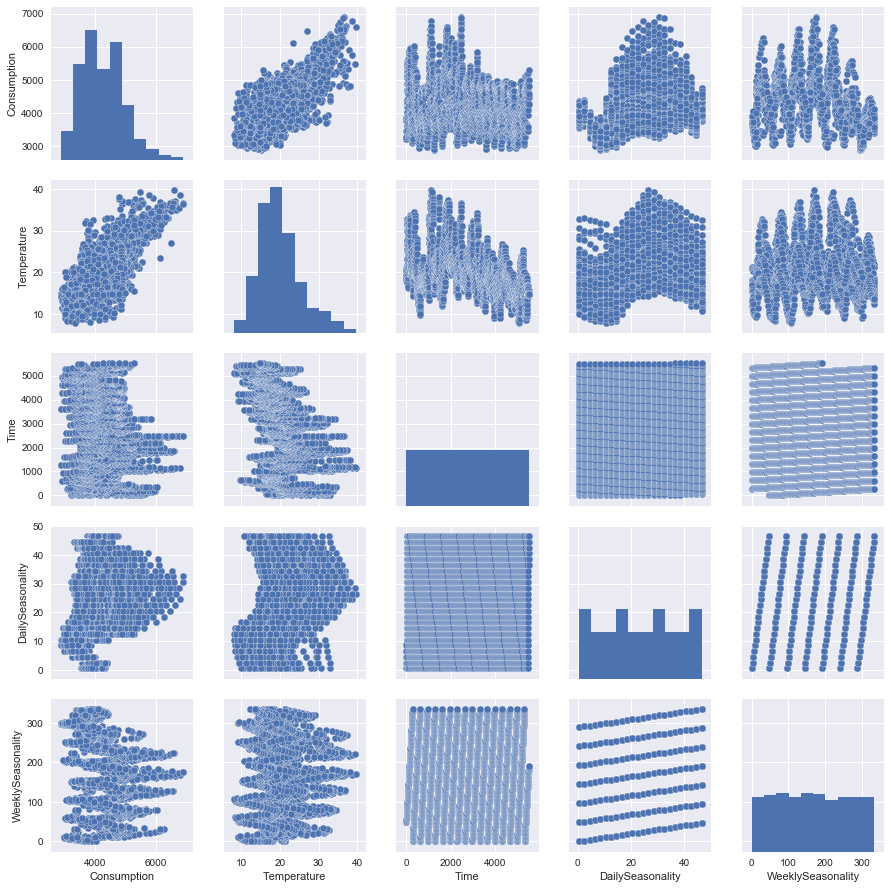

In [356]:
sns.pairplot(data)

Из этим графиков, в частности видим зависимость между температурой и спросом на электричество, причем эта зависимость похожа на линейную. (Также из графиков видим, что спрос на электричество зависит и от времени, и от сезонностей)<br>
Теперь посмотрим на корреляцию. Будем использовать коэффициент корреляции Спирмена, так как мы ничего не знаем про нормальность выборок и не до конца уверены в линейной зависимости.

In [357]:
print('Коэффициент корреляции Спирмена:', sps.spearmanr(data['Consumption'], data['Temperature']))

Коэффициент корреляции Спирмена: SpearmanrResult(correlation=0.57907391747697745, pvalue=6.2431038292792897e-247)


Получился немаленький коэффициент корреляции, поэтому зависимость все таки есть.

Разделим выборки на обучение и тест. В тест идет последняя неделя.

In [358]:
train_data = data[:-24*7]
test_data = data[-24*7:]

train_temperature = train_data['Temperature']
test_temperature = test_data['Temperature']
train_consumption = train_data['Consumption']
test_consumption = test_data['Consumption']

### Смотрим на тренд, сезонности и остатки

Теперь разложим ряд на тренд, сезонность и ошибку с помощью STL-декомпозиции. Заметим, что мы имеем дело с аддитивной моделью. <br>
У нас есть 3 вида сезонностей - дневная, недельная и месячная.

In [359]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [360]:
daily_temperature = seasonal_decompose(np.array(train_temperature), freq=24)
weekly_temperature = seasonal_decompose(np.array(train_temperature), freq=7*24)
mounthly_temperature = seasonal_decompose(np.array(train_temperature), freq=30*24)

daily_consumption = seasonal_decompose(np.array(train_consumption), freq=24)
weekly_consumption = seasonal_decompose(np.array(train_consumption), freq=7*24)
mounthly_consumption = seasonal_decompose(np.array(train_consumption), freq=30*24)

Построим графики для температуры.

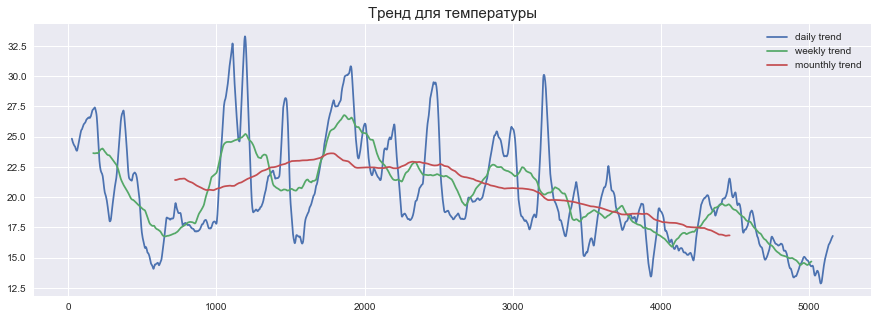

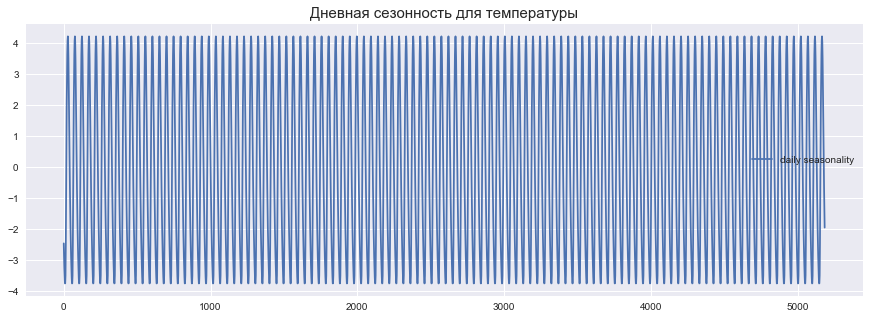

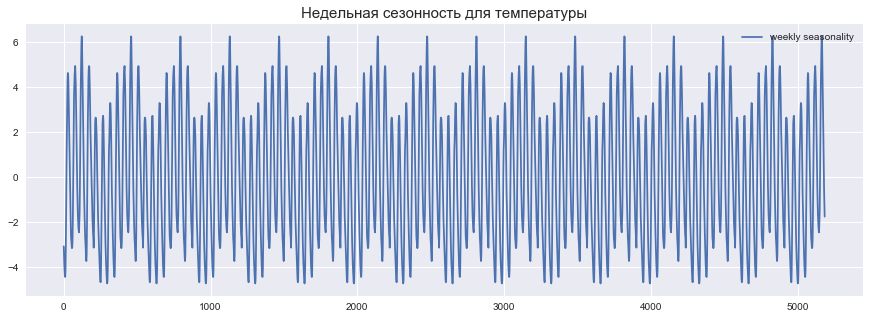

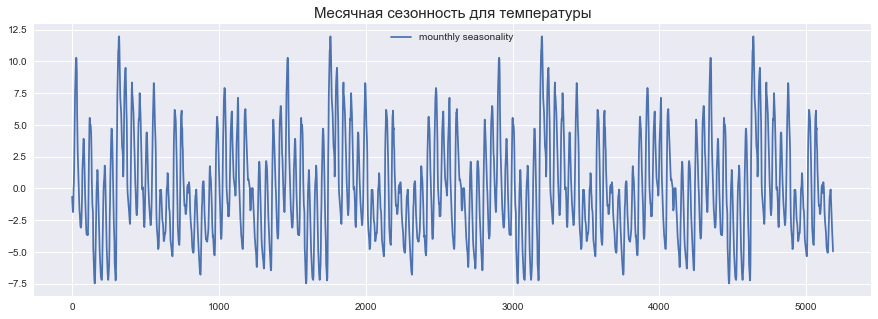

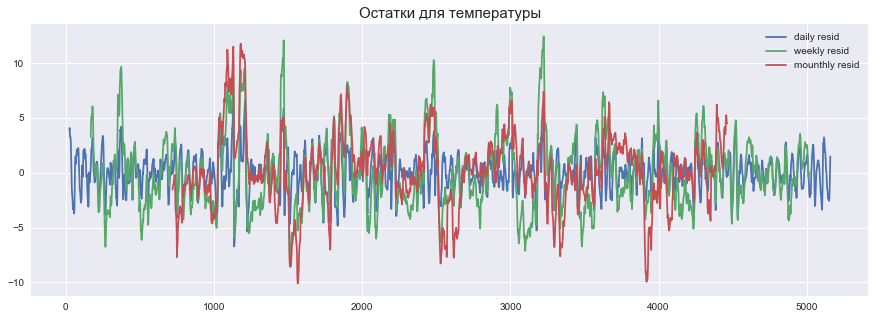

In [361]:
plt.figure(figsize=(15, 5))
plt.plot(train_data['Time'], daily_temperature.trend, label='daily trend')
plt.plot(train_data['Time'], weekly_temperature.trend, label='weekly trend')
plt.plot(train_data['Time'], mounthly_temperature.trend, label='mounthly trend')
plt.title('Тренд для температуры', fontsize=15)
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(train_data['Time'], daily_temperature.seasonal, label='daily seasonality')
plt.title('Дневная сезонность для температуры', fontsize=15)
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(train_data['Time'], weekly_temperature.seasonal, label='weekly seasonality')
plt.title('Недельная сезонность для температуры', fontsize=15)
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(train_data['Time'], mounthly_temperature.seasonal, label='mounthly seasonality')
plt.title('Месячная сезонность для температуры', fontsize=15)
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(train_data['Time'], daily_temperature.resid, label='daily resid')
plt.plot(train_data['Time'], weekly_temperature.resid, label='weekly resid')
plt.plot(train_data['Time'], mounthly_temperature.resid, label='mounthly resid')
plt.title('Остатки для температуры', fontsize=15)
plt.legend()
plt.show()

Как видим, в случае разбиения с месячной сезонностью тренд получился более сглаженным, чем в недельной сезонности, а в недельной сезонности более сглаженнным, чем в случае дневоной, что логично. Остатки же в случае рассматривания месячной сезонности получились чуть больше по модулю, чем остатки при недельной сезонности. А остатки в случае недельной сезонности сильно отличаются по модулю от остатков при рассмотрении дневной сезонности. Это также логично из-за сглаженнности тренда.

Построим то же самое для спроса на электричество.

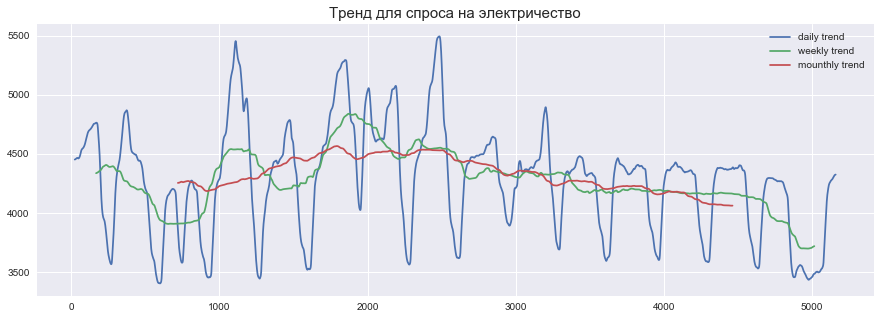

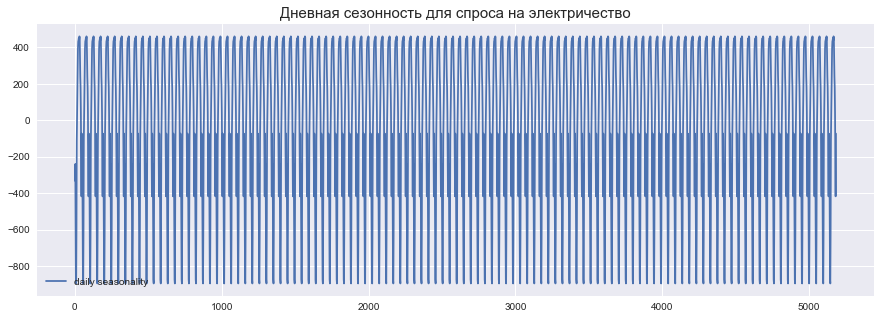

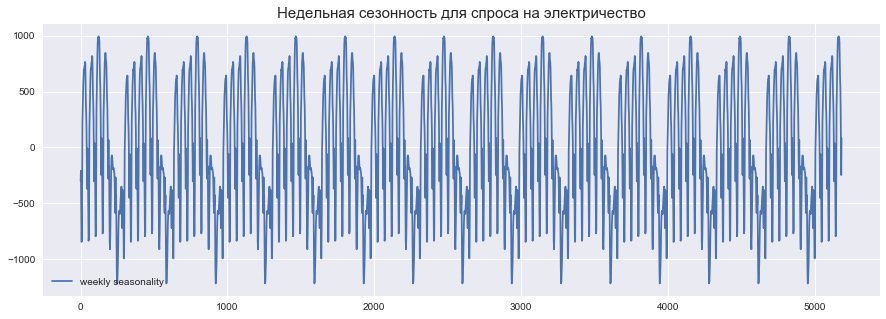

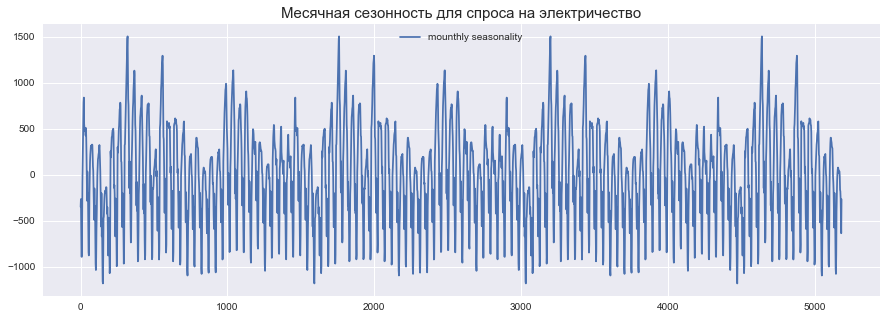

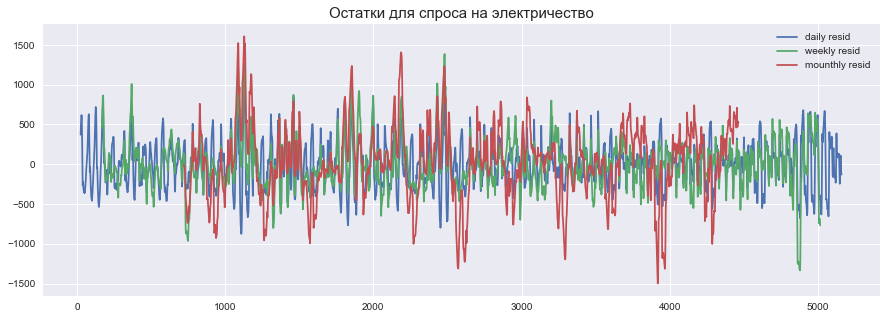

In [362]:
plt.figure(figsize=(15, 5))
plt.plot(train_data['Time'], daily_consumption.trend, label='daily trend')
plt.plot(train_data['Time'], weekly_consumption.trend, label='weekly trend')
plt.plot(train_data['Time'], mounthly_consumption.trend, label='mounthly trend')
plt.title('Тренд для спроса на электричество', fontsize=15)
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(train_data['Time'], daily_consumption.seasonal, label='daily seasonality')
plt.title('Дневная сезонность для спроса на электричество', fontsize=15)
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(train_data['Time'], weekly_consumption.seasonal, label='weekly seasonality')
plt.title('Недельная сезонность для спроса на электричество', fontsize=15)
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(train_data['Time'], mounthly_consumption.seasonal, label='mounthly seasonality')
plt.title('Месячная сезонность для спроса на электричество', fontsize=15)
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(train_data['Time'], daily_consumption.resid, label='daily resid')
plt.plot(train_data['Time'], weekly_consumption.resid, label='weekly resid')
plt.plot(train_data['Time'], mounthly_consumption.resid, label='mounthly resid')
plt.title('Остатки для спроса на электричество', fontsize=15)
plt.legend()
plt.show()

Видим похожую картину в плане сглаженности тренда и остатков.

#### Проверяем на стационарность

Теперь проверим исходные ряды и их остатки на стационарность при помощи критерия KPSS. Множественную проверку гипотез будем проводить отдельно для температуры, отдельно для электричества

In [363]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [367]:
from statsmodels.tsa.stattools import kpss
train_temperature = np.array(train_temperature)
train_consumption = np.array(train_consumption)

daily_resid = daily_temperature.resid
weekly_resid = weekly_temperature.resid
mounthly_resid = mounthly_temperature.resid

kpss_train = kpss(train_temperature)
kpss_daily = kpss(daily_resid[np.isnan(daily_resid) == False])
kpss_weekly = kpss(weekly_resid[np.isnan(weekly_resid) == False])
kpss_mounthly = kpss(mounthly_resid[np.isnan(mounthly_resid) == False])

#множественнная проверка гипотез
result = multipletests([kpss_train[1], kpss_daily[1], kpss_weekly[1], kpss_mounthly[1]])

print('Критерий KPSS для исходного ряда температуры\n Отвергаем ли гипотезу? {},  p-value: {}'
      .format(result[0][0], result[1][0]))
print('Критерий KPSS остатков температуры при выделении дневной сезонности\n Отвергаем ли гипотезу? {},  p-value: {}'
      .format(result[0][1], result[1][1]))
print('Критерий KPSS остатков температуры при выделении недельной сезонности\n Отвергаем ли гипотезу? {},  p-value: {}'
      .format(result[0][2], result[1][2]))
print('Критерий KPSS остатков температуры при выделении месячной сезонности\n Отвергаем ли гипотезу? {},  p-value: {}'
      .format(result[0][3], result[1][3]))

daily_resid = daily_consumption.resid
weekly_resid = weekly_consumption.resid
mounthly_resid = mounthly_consumption.resid

kpss_train = kpss(train_temperature)
kpss_daily = kpss(daily_resid[np.isnan(daily_resid) == False])
kpss_weekly = kpss(weekly_resid[np.isnan(weekly_resid) == False])
kpss_mounthly = kpss(mounthly_resid[np.isnan(mounthly_resid) == False])

#множественнная проверка гипотез
result = multipletests([kpss_train[1], kpss_daily[1], kpss_weekly[1], kpss_mounthly[1]])

print('\nКритерий KPSS для исходного ряда спроса\n Отвергаем ли гипотезу? {},  p-value: {}'
      .format(result[0][0], result[1][0]))
print('Критерий KPSS остатков спроса при выделении дневной сезонности\n Отвергаем ли гипотезу? {},  p-value: {}'
      .format(result[0][1], result[1][1]))
print('Критерий KPSS остатков спроса при выделении недельной сезонности\n Отвергаем ли гипотезу? {},  p-value: {}'
      .format(result[0][2], result[1][2]))
print('Критерий KPSS остатков спроса при выделении месячной сезонности\n Отвергаем ли гипотезу? {},  p-value: {}'
      .format(result[0][3], result[1][3]))



Критерий KPSS для исходного ряда температуры
 Отвергаем ли гипотезу? True,  p-value: 0.039403990000000055
Критерий KPSS остатков температуры при выделении дневной сезонности
 Отвергаем ли гипотезу? False,  p-value: 0.2709999999999999
Критерий KPSS остатков температуры при выделении недельной сезонности
 Отвергаем ли гипотезу? False,  p-value: 0.2709999999999999
Критерий KPSS остатков температуры при выделении месячной сезонности
 Отвергаем ли гипотезу? False,  p-value: 0.2709999999999999

Критерий KPSS для исходного ряда спроса
 Отвергаем ли гипотезу? True,  p-value: 0.039403990000000055
Критерий KPSS остатков спроса при выделении дневной сезонности
 Отвергаем ли гипотезу? False,  p-value: 0.2709999999999999
Критерий KPSS остатков спроса при выделении недельной сезонности
 Отвергаем ли гипотезу? False,  p-value: 0.2709999999999999
Критерий KPSS остатков спроса при выделении месячной сезонности
 Отвергаем ли гипотезу? False,  p-value: 0.2709999999999999


Как и ожидалось исходные ряды не станционарны, так как у них есть тренд и сезонность(отвергли гипотезу об их стацианарности).  Остатки же судя по всему являются стационарными (не отверги гипотезу об их стационарности)<br> <br>

#### Приводим ряды к стационарным
Теперь приведем исходные ряды к стационарным. Для этого сначала сделаем стабилизицию дисперсии.<br>
Заметим, что чисто логически у ряда температур есть только дневная сезонность, так как это температура (ну еще есть годовая, ее учитывать не будем в связи с небольшим объемом данных). У спроса на электричество же есть и дневная и недельная сезонность (и месячная). <br>
Также заметим, что в модели SARIMA мы можем учитывать только одну сезонность, а в ряде спроса на электричество у нас сразу несколько сезонностей. Выберем в качестве этой сезонности дневную, так как она показалась наиболее ярко выраженной (да и чисто логически от нее спрос на электричесво должен зависеть больше). Будем строить модель SARIMA (и предсказывать) для уже продиференцированного по неделям ряда (то есть без учета недельной сезонности), а потом просто проинтегрируем полученный ряд. Если пытаться предсказывать исходный ряд с дневной сезонностью, то при выборе параметров по графику автокорреляции и частичной автокорреляции возникнут трудности.<br>

Для стабилизации дисперсии к ряду температур применим преобразование Бокса-Кокса, а к ряду спроса на электричество логарифмирование.

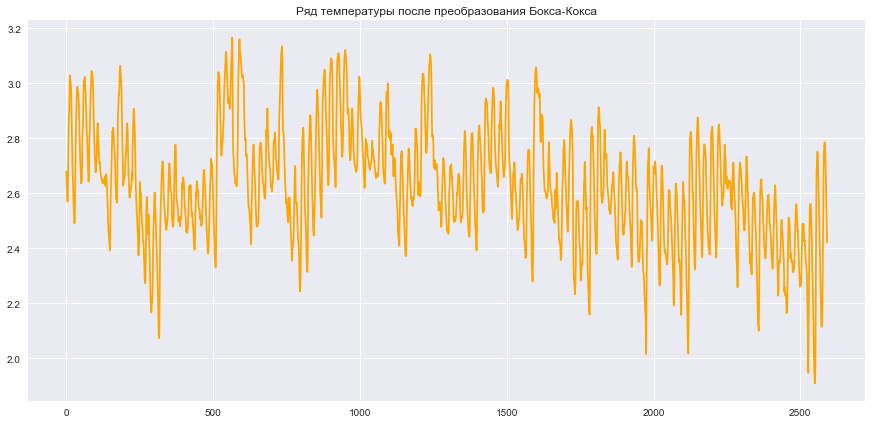

Оптимальный параметр преобразования Бокса-Кокса: -0.083878
Критерий KPSS для полученного ряда температуры 
 (2.4521346174390239, 0.01, 28, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


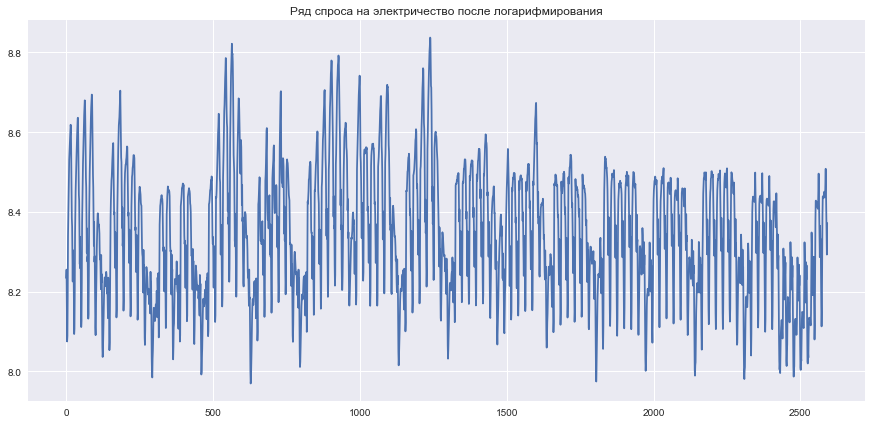

Критерий KPSS для полученного ряда спроса на электричество 
 (0.65215114056078693, 0.017895350858110275, 28, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


In [368]:
train_temperature, lambd = sps.boxcox(train_temperature)

plt.figure(figsize=(15,7))
plt.plot(train_temperature, c= 'orange')
plt.title('Ряд температуры после преобразования Бокса-Кокса')
plt.show()

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lambd)
print('Критерий KPSS для полученного ряда температуры \n', kpss(train_temperature))

train_consumption = np.log(train_consumption)
plt.figure(figsize=(15,7))
plt.plot(train_consumption)
plt.title('Ряд спроса на электричество после логарифмирования')
plt.show()

print('Критерий KPSS для полученного ряда спроса на электричество \n', kpss(train_consumption))

Как видим по графикам дисперсия действительно стабилизировалась.

Дифференцируем ряд температур

Критерий КПСС после сезонных дифференцирований и последующего дифференцированния 
:  (0.0053764787429678241, 0.1, 28, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


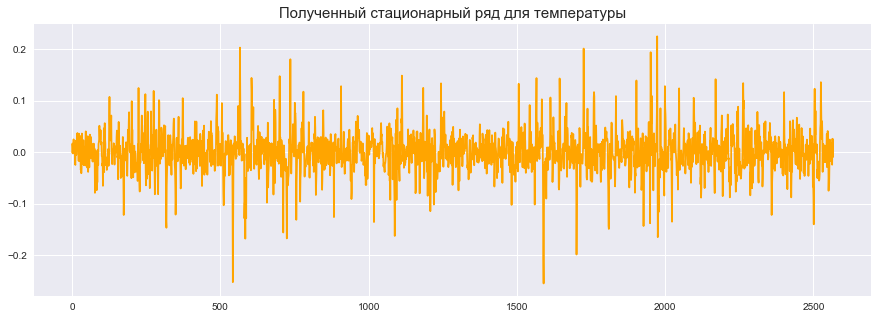

In [369]:
#по дням 
train_temperature_stat = train_temperature[24:] - train_temperature[:-24]
#обычное дифференцирование

train_temperature_stat = train_temperature_stat[1:] - train_temperature_stat[:-1]
print('Критерий КПСС после сезонных дифференцирований и последующего дифференцированния \n: ', 
      kpss(train_temperature_stat))
plt.figure(figsize=(15, 5))
plt.plot(train_temperature_stat, c='orange')
plt.title('Полученный стационарный ряд для температуры', fontsize=15)
plt.show()

Для спроса на электричество. <br>
Продифференцируем ряд сезонно по неделям и сохраним результат, так как строить модель SARIMA будем именно на нем.

Критерий КПСС после сезонных дифференцирований по неделям и дням и последующего дифференцированния 
: (0.0059829443388027424, 0.1, 27, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


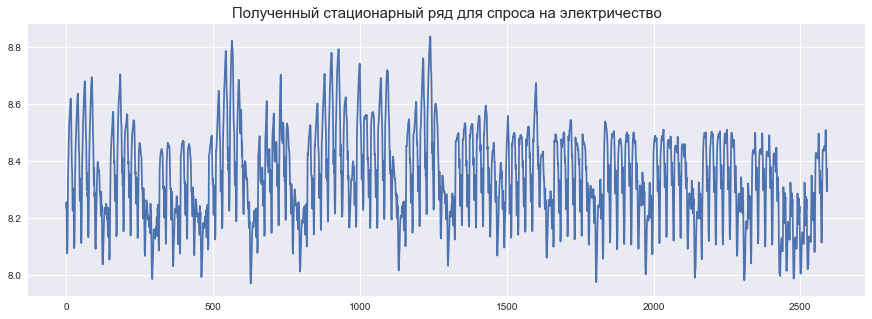

In [370]:
train_consumption = np.array(train_consumption)
#по неделям
train_consumption_stat_week = train_consumption[7*24:] - train_consumption[:-7*24]
#по дням
train_consumption_stat = train_consumption_stat_week[24:] - train_consumption_stat_week[:-24]
#обычное дифференцирование
train_consumption_stat = train_consumption_stat[1:] - train_consumption_stat[:-1]

print('Критерий КПСС после сезонных дифференцирований по неделям и дням и последующего дифференцированния \n:', 
      kpss(train_consumption_stat))
plt.figure(figsize=(15, 5))
plt.plot(train_consumption)
plt.title('Полученный стационарный ряд для спроса на электричество', fontsize=15)
plt.show()

Видим, что теперь наши ряды стали стационарными. <br>
#### Выбор d и D
**Для ряда температуры** <br>
Мы один раз сезонно продифференцировали исходный ряд, поэтому $D=1$, и один раз обычно продифференцировали, поэтому $d=1$ <br>
**Для спроса на электричество** <br>
После недельного дифференцирования мы получили ряд, на котором в итоге будем строить модель. А для этого ряда мы провели одно сезонное дифференцирование (по дням) и одно обычное. Таким образом, выбрали $d = 1, D = 1$

#### Выбор остальных параметров по ACF и PACF

Построим графики ACF и PACF для полученных рядов. <br> <br>
##### Для температуры.
Сначала построим 2 графика автокорелляции для нахождения q и Q

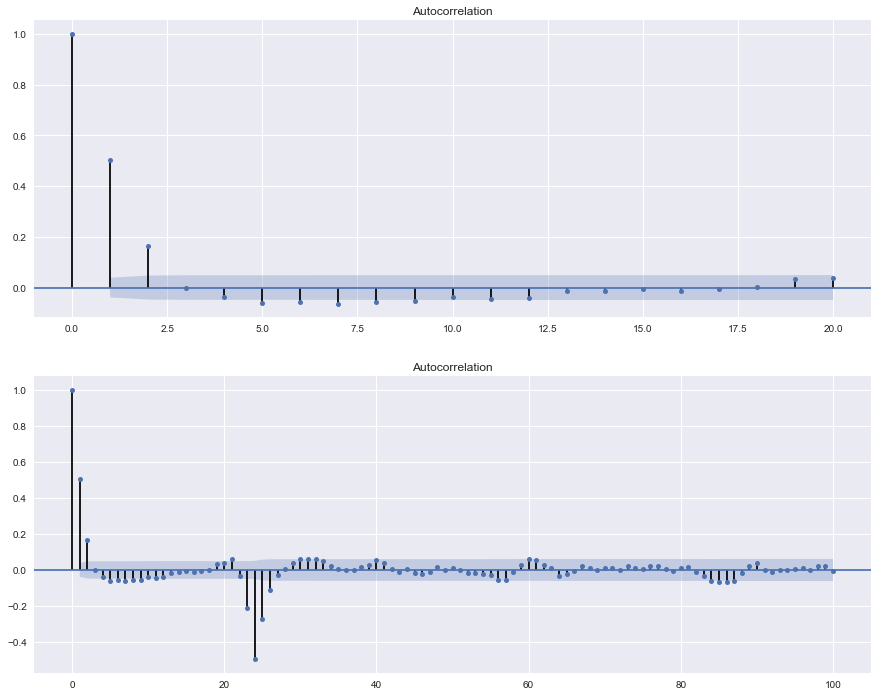

In [26]:
import statsmodels.api as sm

fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_temperature_stat, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(train_temperature_stat, lags=100, ax=ax2)
plt.show()

Видим, что в качестве начального приближения для $q$ и $Q$ можно взять $q = 2, Q = 1$ <br>
Теперь построим графики частичной автокорелляции

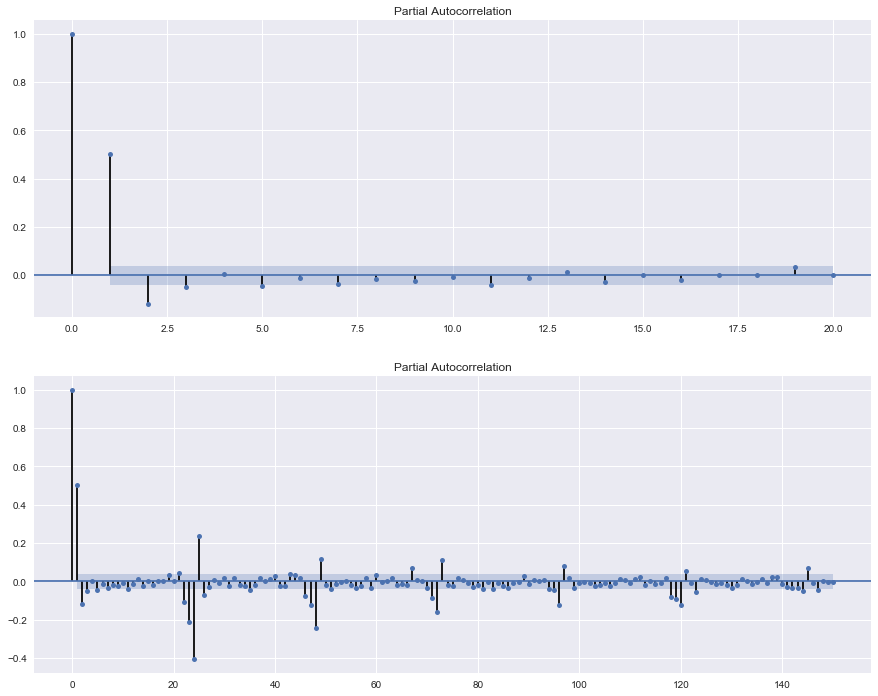

In [27]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(train_temperature_stat, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_temperature_stat, lags=150, ax=ax2)
plt.show()

Видим, что в качестве начального приближения для $p$ и $P$ можно взять $p = 2 , P = 5$

##### Теперь для спроса на электричество.
Сначала тукже построим 2 графика автокорелляции для нахождения q и Q

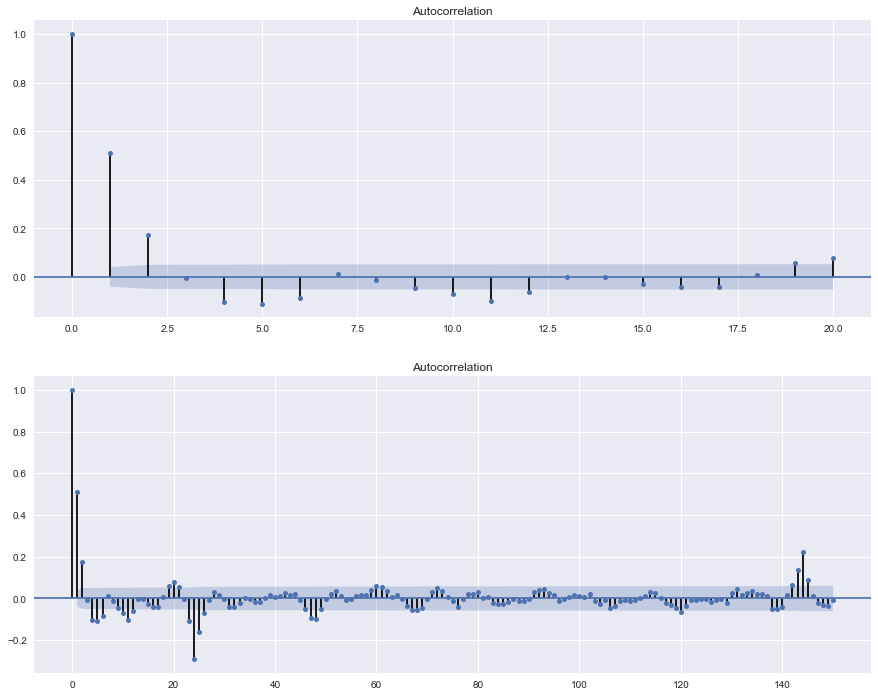

In [28]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_consumption_stat, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(train_consumption_stat, lags=150, ax=ax2)
plt.show()

Видим, что в качестве начального приближения для $q$ и $Q$ можно взять $q = 2, Q = 2$ <br>
Теперь построим графики частичной автокорелляции

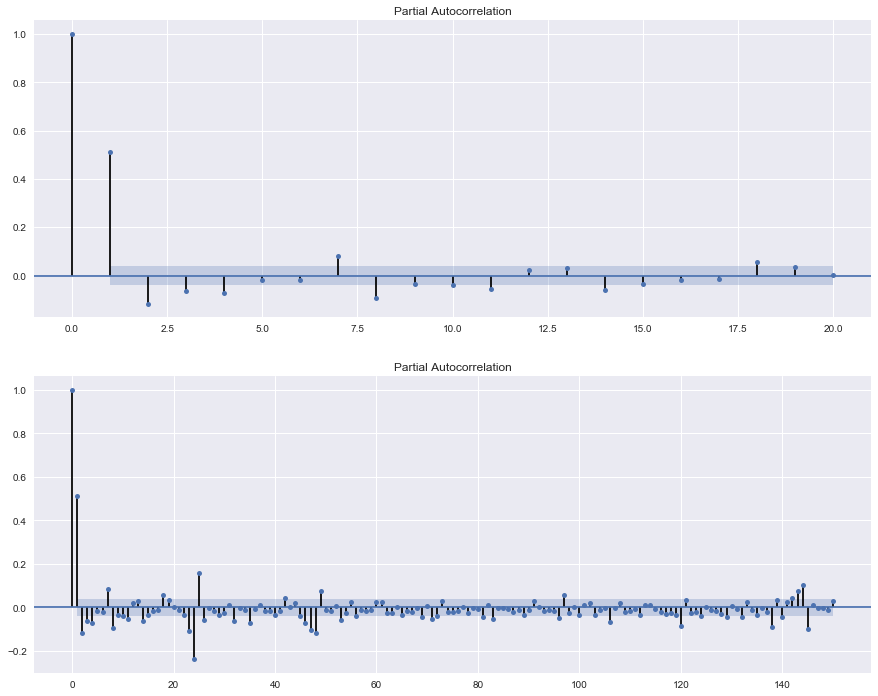

In [29]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(train_consumption_stat, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_consumption_stat, lags=150, ax=ax2)
plt.show()

Видим, что в качестве начального приближения для $p$ и $P$ можно взять $p = 2 , P = 2$

## Производим перебор по параметрам и делаем предсказания
 ### Для ряда температур

In [30]:
S = 24
Q = range(2)
q = range(3)
p = range(1,3)
P = range(2,6)
d = [1]
D = [1]

In [31]:
import itertools
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], S) for x in list(itertools.product(P, D, Q))]


In [32]:
best_aic = 1e15
best_params = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(train_temperature, order=param, seasonal_order=param_seasonal, 
                                              enforce_stationarity=False, enforce_invertibility=False)
            model = model.fit()
            print('ARIMA{}x{} – AIC:{}'.format(param, param_seasonal, model.aic))
            if(model.aic < best_aic):
                best_aic = model.aic
                best_params = [param, param_seasonal]
        except:
            pass


ARIMA(1, 1, 0)x(2, 1, 0, 24) – AIC:-10846.680088371912
ARIMA(1, 1, 0)x(2, 1, 1, 24) – AIC:-11376.757264416927
ARIMA(1, 1, 0)x(3, 1, 0, 24) – AIC:-10860.923801421668


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(3, 1, 1, 24) – AIC:-11256.18486119429


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(4, 1, 0, 24) – AIC:-10823.5967605011


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(4, 1, 1, 24) – AIC:-11140.295763362157
ARIMA(1, 1, 0)x(5, 1, 0, 24) – AIC:-10794.349445888376


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(5, 1, 1, 24) – AIC:-10819.225636576022
ARIMA(1, 1, 1)x(2, 1, 0, 24) – AIC:-10869.583745831613


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 1, 1, 24) – AIC:-11401.418343319301
ARIMA(1, 1, 1)x(3, 1, 0, 24) – AIC:-10881.845656938936


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(3, 1, 1, 24) – AIC:-11250.808256424189
ARIMA(1, 1, 1)x(4, 1, 0, 24) – AIC:-10841.57661430477


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(4, 1, 1, 24) – AIC:-11097.09774742628
ARIMA(1, 1, 1)x(5, 1, 0, 24) – AIC:-10809.704679371072


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(5, 1, 1, 24) – AIC:-11054.527901163849


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 0, 24) – AIC:-10872.146836225515
ARIMA(1, 1, 2)x(2, 1, 1, 24) – AIC:-11408.455340880619


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(3, 1, 0, 24) – AIC:-10884.850866972743


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(3, 1, 1, 24) – AIC:-11282.74132737369


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(4, 1, 0, 24) – AIC:-10843.137890854348


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(4, 1, 1, 24) – AIC:-11162.097471439072
ARIMA(1, 1, 2)x(5, 1, 0, 24) – AIC:-10810.109333891569


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(5, 1, 1, 24) – AIC:-11031.195213231915
ARIMA(2, 1, 0)x(2, 1, 0, 24) – AIC:-10868.354408638288


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 1, 1, 24) – AIC:-11400.151695096467
ARIMA(2, 1, 0)x(3, 1, 0, 24) – AIC:-10880.702864935707


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(3, 1, 1, 24) – AIC:-11280.079319909373
ARIMA(2, 1, 0)x(4, 1, 0, 24) – AIC:-10839.548304792927


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(4, 1, 1, 24) – AIC:-11157.262991436406
ARIMA(2, 1, 0)x(5, 1, 0, 24) – AIC:-10807.650345091006


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(5, 1, 1, 24) – AIC:-10946.085372487412
ARIMA(2, 1, 1)x(2, 1, 0, 24) – AIC:-10872.30863730094


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 1, 1, 24) – AIC:-11433.437997765337


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(3, 1, 0, 24) – AIC:-10884.892652343235


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(3, 1, 1, 24) – AIC:-11284.260916088886


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(4, 1, 0, 24) – AIC:-10843.801771539875


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(4, 1, 1, 24) – AIC:-11101.951877642026


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(5, 1, 0, 24) – AIC:-10813.906818963851


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(5, 1, 1, 24) – AIC:-11024.109857984688
ARIMA(2, 1, 2)x(2, 1, 0, 24) – AIC:-10867.738662609981


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 1, 1, 24) – AIC:-11398.657604375065


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(3, 1, 0, 24) – AIC:-10880.118752442551


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(3, 1, 1, 24) – AIC:-11269.123022697666
ARIMA(2, 1, 2)x(4, 1, 0, 24) – AIC:-10839.02647570744


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(4, 1, 1, 24) – AIC:-11125.874051463481


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(5, 1, 0, 24) – AIC:-10808.39220464602


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(5, 1, 1, 24) – AIC:-11016.042814234854


Слишком поздно заметила ворнинги, чтобы перезапускать ячейку

Посмотрим на лучшие параметры

In [33]:
print('Лучшие параметры: ARIMA{}x{} – AIC:{}'.format(best_params[0], best_params[1], best_aic))

Лучшие параметры: ARIMA(2, 1, 1)x(2, 1, 1, 24) – AIC:-11433.437997765337


Построим и обучим модель на этих параметрах. 

In [144]:
model = sm.tsa.statespace.SARIMAX(train_temperature, order=best_params[0], seasonal_order=best_params[1], 
                                              enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()

Выведем некоторые статистические свойства

In [38]:
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4797      0.015     97.206      0.000       1.450       1.509
ar.L2         -0.5390      0.012    -43.200      0.000      -0.563      -0.515
ma.L1         -0.9560      0.012    -77.670      0.000      -0.980      -0.932
ar.S.L24       0.0185      0.020      0.940      0.347      -0.020       0.057
ar.S.L48       0.0291      0.020      1.446      0.148      -0.010       0.069
ma.S.L24      -0.9605      0.007   -132.172      0.000      -0.975      -0.946
sigma2         0.0006   9.45e-06     64.009      0.000       0.001       0.001


Посмотрим на график остатков, гистограмму остатков и на  Q-Q plot 

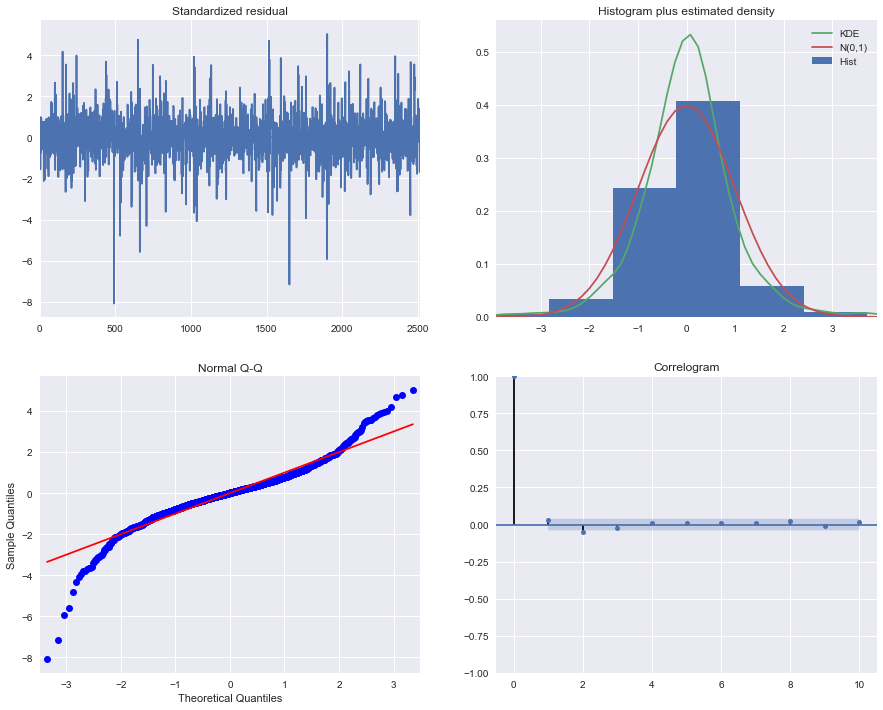

In [39]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

Как видим на  Q-Q plot точки лежат почти на одной прямой.

Делаем пресказание. Получаем значения и связанные с ними доверительные интервалы. <br>
Сначала посмотрим на предсказания на последней неделе данных, на которых обучались.

In [145]:
predictions = model.get_prediction(start=len(train_temperature) - 24*7, dynamic=True)
pred_ci = predictions.conf_int()

Смотрим на предсказание ряда температуры, после применения преобразования Бокса-Кокса

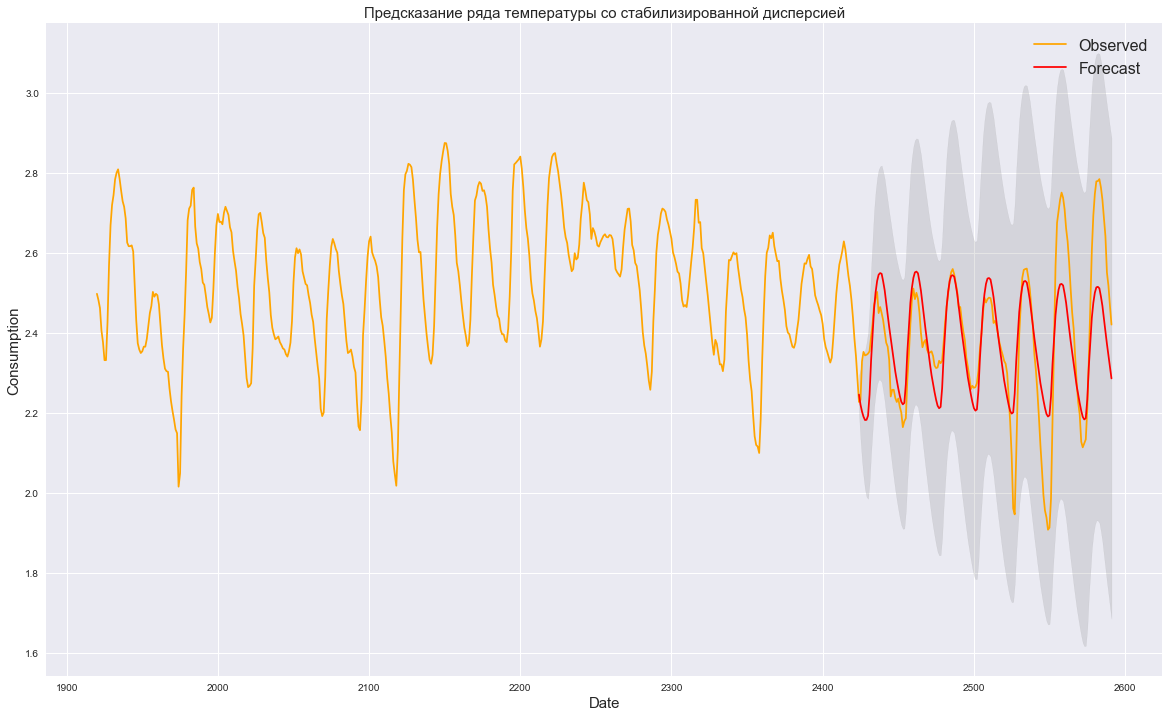

In [150]:
length = len(train_temperature)
plt.figure(figsize=(20, 12))
plt.plot(np.arange(length-4*24*7, length), train_temperature[-4*24*7:],color='orange',  label='Observed')
plt.plot(np.arange(length-24*7, length) , predictions.predicted_mean, label='Forecast', color='red')
plt.fill_between(pred_ci.index + len(train_temperature) - 24*7, 
                 pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='gray', alpha=.2)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Consumption', fontsize=15)
plt.legend(fontsize=16)
plt.title('Предсказание ряда температуры со стабилизированной дисперсией', fontsize=15)
plt.show()

Теперь посмотрим на предсказания для исходного ряда температуры. Для этого применим к предсказанным значениям преобразование обратное преобразованию Бокса Кокса

In [57]:
#функция, производящая обратное преобразование к преобразованию Бокса-Кокса
def boxcox_inverted(data_boxcox, lambd):
    return (lambd*data_boxcox + 1) ** (1 / lambd)

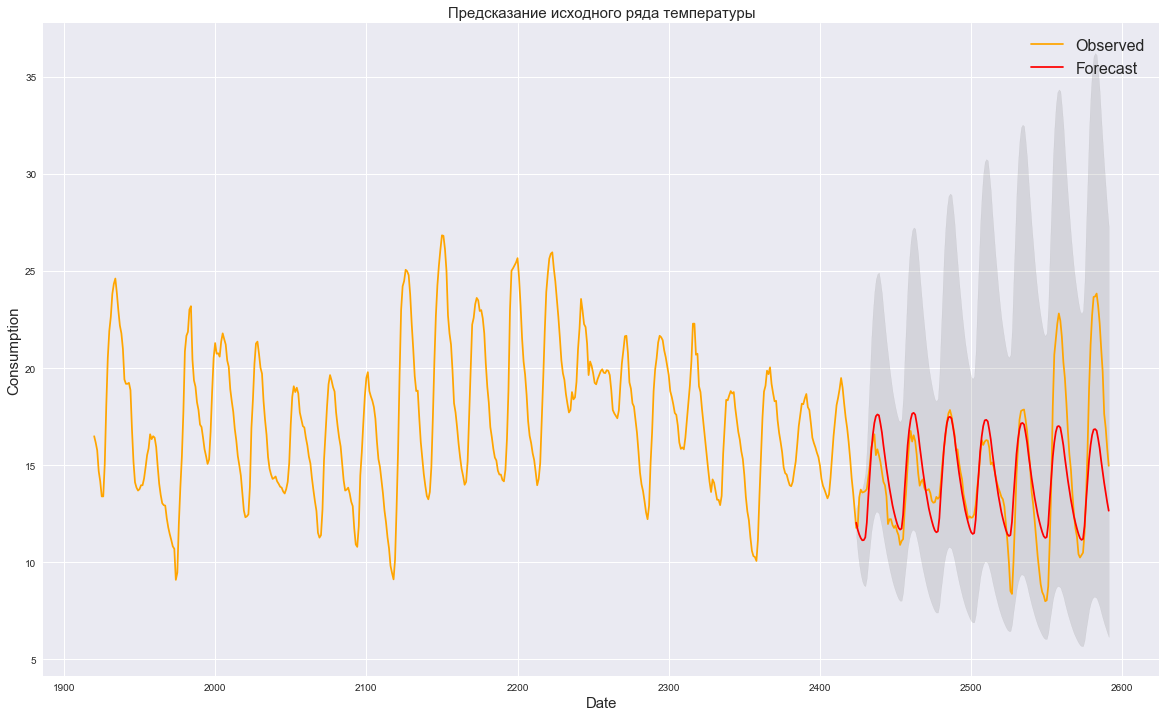

In [151]:
length = len(train_temperature)
plt.figure(figsize=(20, 12))
plt.plot(np.arange(length-4*24*7, length), boxcox_inverted(train_temperature[-4*24*7:], lambd) ,
         color='orange',  label='Observed')
plt.plot(np.arange(length-24*7, length) , boxcox_inverted(predictions.predicted_mean, lambd),
         label='Forecast', color='red')
plt.fill_between(pred_ci.index + len(train_temperature) - 24*7, 
                 boxcox_inverted(pred_ci.iloc[:, 0], lambd), 
                 boxcox_inverted(pred_ci.iloc[:, 1], lambd), color='gray', alpha=.2)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Consumption', fontsize=15)
plt.legend(fontsize=16)
plt.title('Предсказание исходного ряда температуры', fontsize=15)
plt.show()

Посмотрим на среднеквадратичную ошибку

In [63]:
truth = boxcox_inverted(train_temperature[-24*7:], lambd)
forecasts = boxcox_inverted(predictions.predicted_mean, lambd)
mse = ((forecasts - truth) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(round(mse, 2)))

Среднеквадратичная ошибка: 5.31


Построим предсказание в будущее (то есть предскажем тестовую выборку)

In [71]:
pred_uc = model.get_forecast(steps=24*7)
pred_ci = pred_uc.conf_int()


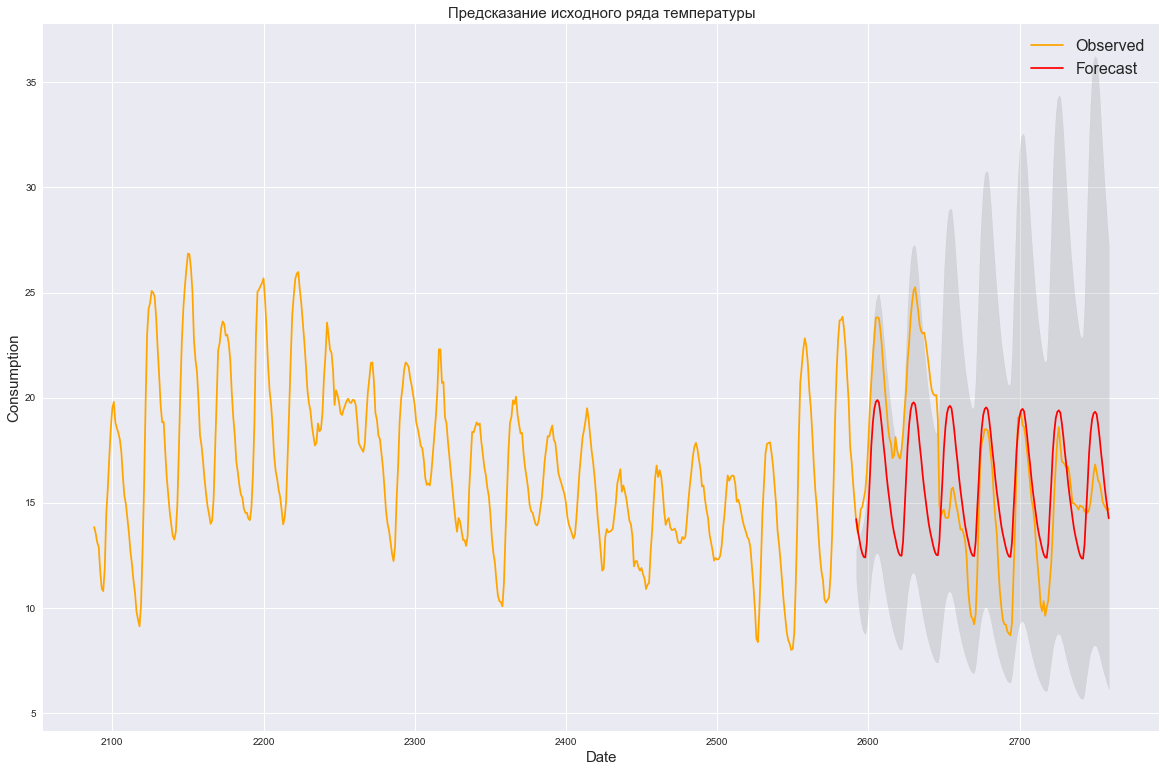

In [158]:
length = len(train_temperature)
plt.figure(figsize=(20, 13))
plt.plot(np.arange(length-3*24*7, length+24*7), np.array(data['Temperature'])[-4*24*7:],
         color='orange',  label='Observed')
plt.plot(np.arange(length, length+24*7) , boxcox_inverted(pred_uc.predicted_mean, lambd),
         label='Forecast', color='red')
plt.fill_between(pred_ci.index + len(train_temperature), 
                 boxcox_inverted(pred_ci.iloc[:, 0], lambd), 
                 boxcox_inverted(pred_ci.iloc[:, 1], lambd), color='gray', alpha=.2)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Consumption', fontsize=15)
plt.legend(fontsize=16)
plt.title('Предсказание исходного ряда температуры', fontsize=15)
plt.show()

Посчитаем среднеквадратичную ошибку на тестовых данных.

In [74]:
truth = test_temperature
forecasts = boxcox_inverted(pred_uc.predicted_mean, lambd)
mse = ((forecasts - truth) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(round(mse, 2)))

Среднеквадратичная ошибка: 11.38


Чуть хуже. чем на обучающей выборке, но все равно неплохо.

### Для ряда спроса на электричество
(Предсказываем не сам ряд, а недельно продифференцированный ряд) <br>
Ранее нашли приближения: $q = 2, Q = 2, p = 2, P = 2$

In [75]:
S = 24
Q = range(3)
q = range(3)
p = range(3)
P = range(3)
d = [1]
D = [1]

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], S) for x in list(itertools.product(P, D, Q))]


Производим перебор по параметрам

In [78]:
best_aic = 1e15
best_params = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(train_consumption_stat_week, order=param, seasonal_order=param_seasonal, 
                                              enforce_stationarity=False, enforce_invertibility=False)
            model = model.fit()
            print('ARIMA{}x{} – AIC:{}'.format(param, param_seasonal, model.aic))
            if(model.aic < best_aic):
                best_aic = model.aic
                best_params = [param, param_seasonal]
        except:
            pass



ARIMA(0, 1, 0)x(0, 1, 1, 24) – AIC:-11189.400779207996
ARIMA(0, 1, 0)x(0, 1, 2, 24) – AIC:-11097.191977711242
ARIMA(0, 1, 0)x(1, 1, 0, 24) – AIC:-11100.673395356207
ARIMA(0, 1, 0)x(1, 1, 1, 24) – AIC:-11403.74944077828
ARIMA(0, 1, 0)x(1, 1, 2, 24) – AIC:-11288.56150081766
ARIMA(0, 1, 0)x(2, 1, 0, 24) – AIC:-11074.486963088775
ARIMA(0, 1, 0)x(2, 1, 1, 24) – AIC:-11082.685573404928
ARIMA(0, 1, 0)x(2, 1, 2, 24) – AIC:-11285.321347437331
ARIMA(0, 1, 1)x(0, 1, 0, 24) – AIC:-11650.789419153407
ARIMA(0, 1, 1)x(0, 1, 1, 24) – AIC:-11859.05261564821
ARIMA(0, 1, 1)x(0, 1, 2, 24) – AIC:-11751.557351081905
ARIMA(0, 1, 1)x(1, 1, 0, 24) – AIC:-11779.082602603623
ARIMA(0, 1, 1)x(1, 1, 1, 24) – AIC:-12068.370132744489
ARIMA(0, 1, 1)x(1, 1, 2, 24) – AIC:-11950.685063664701
ARIMA(0, 1, 1)x(2, 1, 0, 24) – AIC:-11728.767910550567
ARIMA(0, 1, 1)x(2, 1, 1, 24) – AIC:-11959.58162715633
ARIMA(0, 1, 1)x(2, 1, 2, 24) – AIC:-11952.81173002958
ARIMA(0, 1, 2)x(0, 1, 0, 24) – AIC:-11728.512784511842
ARIMA(0, 1, 2)x

In [82]:
print('Лучшие параметры: ARIMA{}x{} – AIC:{}'.format(best_params[0], best_params[1], best_aic))

Лучшие параметры: ARIMA(2, 1, 2)x(1, 1, 1, 24) – AIC:-12230.138063889774


Строим и обучаем модель на этих параметрах

In [278]:
model = sm.tsa.statespace.SARIMAX(train_consumption_stat_week, order=(2, 1, 2), 
                                  seasonal_order=(1, 1, 1, 24), enforce_stationarity=False, 
                                  enforce_invertibility=False)
model = model.fit()

Смотрим на статистические свойства

In [279]:
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3546      0.027     50.449      0.000       1.302       1.407
ar.L2         -0.4049      0.028    -14.671      0.000      -0.459      -0.351
ma.L1         -0.8155      0.055    -14.763      0.000      -0.924      -0.707
ma.L2         -0.1847      0.033     -5.680      0.000      -0.248      -0.121
ar.S.L24       0.5106      0.007     72.960      0.000       0.497       0.524
ma.S.L24      -1.0026      0.055    -18.086      0.000      -1.111      -0.894
sigma2         0.0003   2.33e-05     13.607      0.000       0.000       0.000


График остатков, гистограмма остатков и Q-Q plot

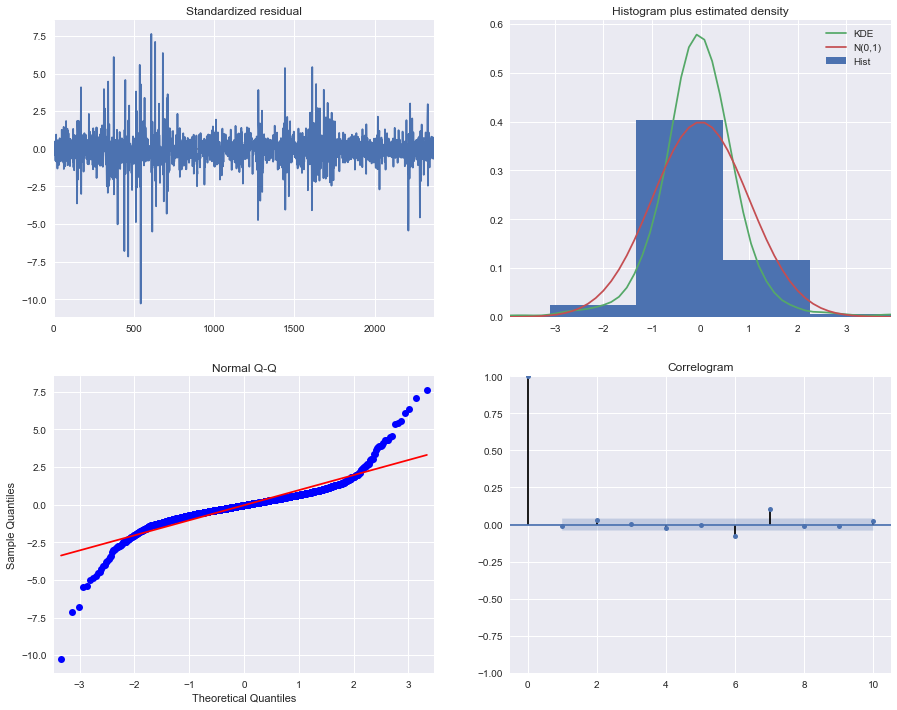

In [280]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

Как видим на  Q-Q plot точки снова лежат почти на одной прямой. <br><br>
Делаем пресказание. <br>
Сначала посмотрим на предсказания на последней неделе данных, на которых обучались.

In [281]:
predictions_2 = model.get_prediction(start=len(train_consumption_stat_week) - 24*7, dynamic=True)
pred_ci_2 = predictions_2.conf_int()

Предсказание ряда спроса на электричество, после применения преобразования Бокса-Кокса и недельного дифференцирования. Будем предсказывать последнюю неделю.

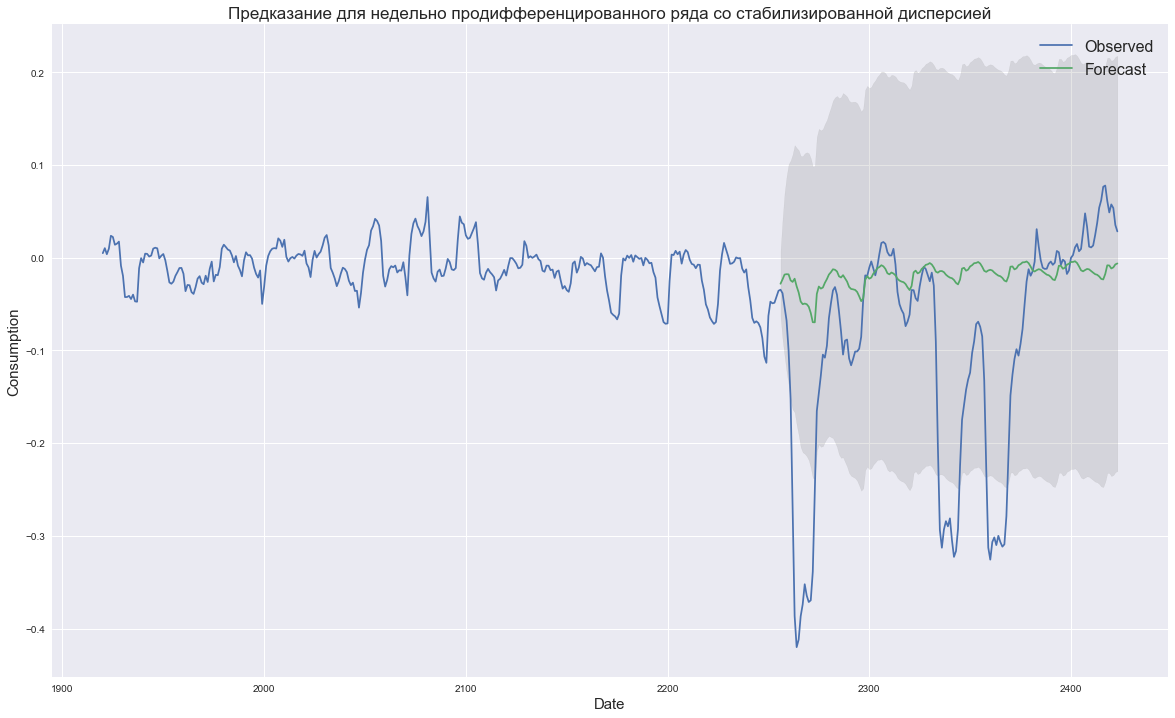

In [282]:
length = len(train_consumption_stat_week)
plt.figure(figsize=(20, 12))
plt.plot(np.arange(length-3*24*7, length),train_consumption_stat_week[-3*24*7:], label='Observed')
plt.plot(np.arange(length-24*7, length) , predictions_2.predicted_mean, label='Forecast')
plt.fill_between(pred_ci_2.index + length - 24*7, 
                pred_ci_2.iloc[:, 0], pred_ci_2.iloc[:, 1], color='gray', alpha=.2)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Consumption', fontsize=15)
plt.legend(fontsize=16)
plt.title('Предказание для недельно продифференцированного ряда со стабилизированной дисперсией', fontsize=17)
plt.show()

Теперь посмотрим на предсказания для исходного ряда спроса на электричество. <br>
Для того, чтобы получить исходный ряд проинтегрируем полученный ряд по неделям. <br>
Пусть исходный ряд $X$, а полученный после недельного дифференцирования $Y$. На данный момент мы получили предсказание для ряда Y.
Тогда $Y[i- 24*7] = X[i] - X[i - 24*7]$ (недельное дифференцирование)<br>
$\Rightarrow X[i] = Y[i - 24*7] + X[i - 24*7]$, то есть зная Y мы последовательно предсказываем ряд X, через значение $X[i - 24*7]$. <br>
Получается, что в нашем случае: $X_{pred} = Y_{pred} + X[-24*7:]$
После также применим преобразование обратное логарифмированию.

In [284]:
#функция, производящая обратное преобразование к преобразованию Бокса-Кокса
def log_inverted(data_log):
    return np.e ** data_log

#интегрируем
def integrate_1(pred_diff):
    return np.array(pred_diff) + np.array(train_consumption[-2*24*7:-24*7])

def inverted_transform_1(data):
    return log_inverted(integrate_1(data))

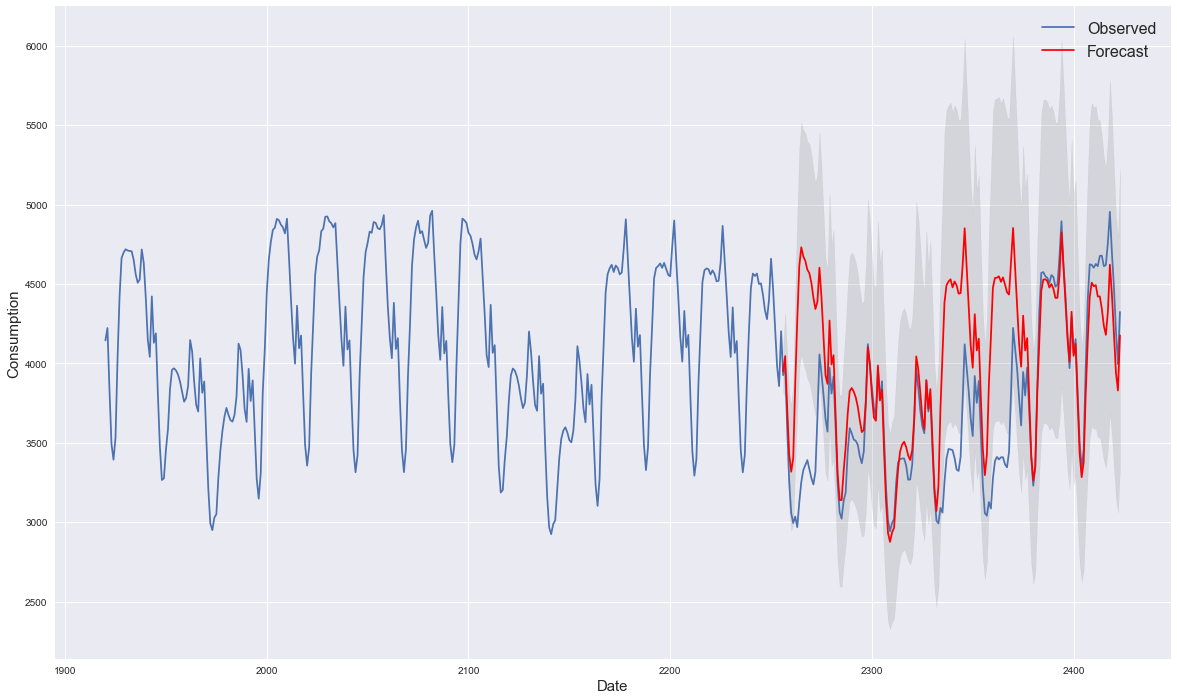

In [285]:
length = len(train_consumption_stat_week)
plt.figure(figsize=(20, 12))
plt.plot(np.arange(length-3*24*7, length), train_data['Consumption'][-3*24*7:]
         , label='Observed')
plt.plot(np.arange(length-24*7, length) , inverted_transform_1(predictions_2.predicted_mean), 
         color='red', label='Forecast')
plt.fill_between(pred_ci_2.index + length - 24*7, 
                 inverted_transform_1(pred_ci_2.iloc[:, 0]), 
                 inverted_transform_1(pred_ci_2.iloc[:, 1]), color='gray', alpha=.2)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Consumption', fontsize=15)
plt.legend(fontsize=16)

plt.show()

Неплохой прогноз. Однако на этих данных мы и обучались <br>
Посмотрим на среднеквадратичную ошибку на обучении

In [286]:
truth = train_data['Consumption'][-24*7:]
forecasts = inverted_transform(predictions_2.predicted_mean)
mse = ((forecasts - truth) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(round(mse, 2)))

Среднеквадратичная ошибка: 305424.89


Ошибка не очень большая (порядок связан с большими значениями самого ряда)

Построим предсказание в будущее (то есть предскажем тестовую выборку)

In [287]:
def integrate_2(pred_diff):
    return np.array(pred_diff) + np.array(train_consumption[-24*7:])

def inverted_transform_2(data):
    return log_inverted(integrate_2(data))

In [288]:
pred_uc_2 = model.get_forecast(steps=24*7)
pred_ci_2 = pred_uc_2.conf_int()

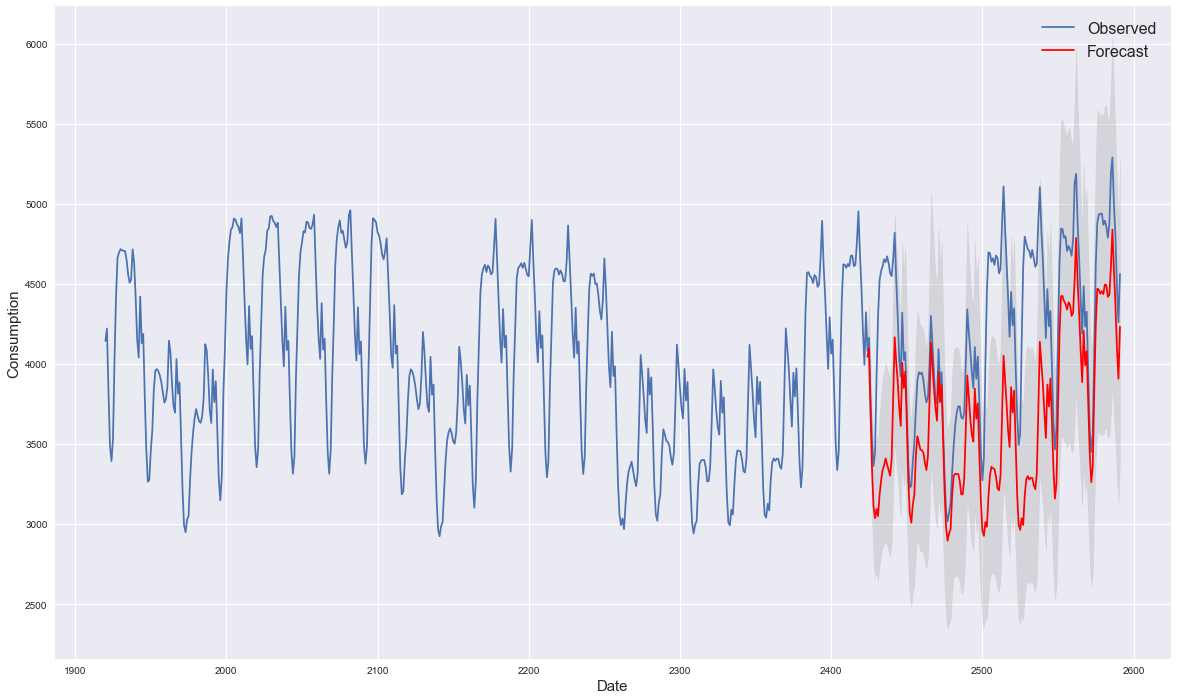

In [289]:
length = len(train_consumption_stat_week)
plt.figure(figsize=(20, 12))
plt.plot(np.arange(length-3*24*7, length+24*7), data['Consumption'][-4*24*7:]
         , label='Observed')
plt.plot(np.arange(length, length+24*7) , inverted_transform_2(pred_uc_2.predicted_mean), 
         color='red', label='Forecast')
plt.fill_between(pred_ci_2.index + length, 
                 inverted_transform_2(pred_ci_2.iloc[:, 0]), 
                 inverted_transform_2(pred_ci_2.iloc[:, 1]), color='gray', alpha=.2)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Consumption', fontsize=15)
plt.legend(fontsize=16)

plt.show()

Посчитаем среднеквадратичную ошибку на тестовых данных.

In [292]:
truth = data['Consumption'][-24*7:]
forecasts = inverted_transform_2(pred_uc_2.predicted_mean)
mse = ((forecasts - truth) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(round(mse, 2)))

Среднеквадратичная ошибка: 509487.21


Ошибка получилась немаленькой. Для сравнения посмотрим еще на одну модель (вторую лучшую по aic) - <br>ARIMA(2, 1, 1)x(1, 1, 1, 24) – AIC:-12180.420945459608. <br>
Для этой модели также посмотрим прогноз будущего.

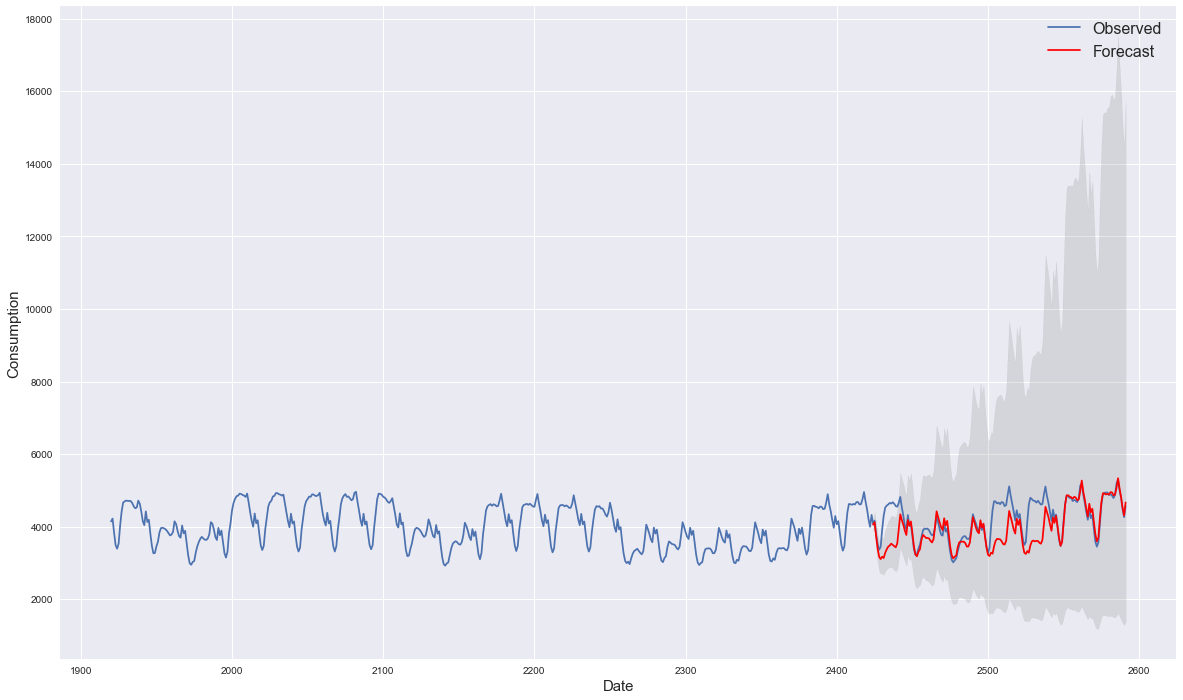

In [293]:
model = sm.tsa.statespace.SARIMAX(train_consumption_stat_week, order=(2, 1, 1), 
                                  seasonal_order=(1, 1, 1, 24), enforce_stationarity=False, 
                                  enforce_invertibility=False)
model = model.fit()

pred_uc_3 = model.get_forecast(steps=24*7)
pred_ci_3 = pred_uc_3.conf_int()

length = len(train_consumption_stat_week)
plt.figure(figsize=(20, 12))
plt.plot(np.arange(length-3*24*7, length+24*7), data['Consumption'][-4*24*7:]
         , label='Observed')
plt.plot(np.arange(length, length+24*7) , inverted_transform_2(pred_uc_3.predicted_mean), 
         color='red', label='Forecast')
plt.fill_between(pred_ci_3.index + length, 
                 inverted_transform_2(pred_ci_3.iloc[:, 0]), 
                 inverted_transform_2(pred_ci_3.iloc[:, 1]), color='gray', alpha=.2)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Consumption', fontsize=15)
plt.legend(fontsize=16)

plt.show()

In [294]:
truth = data['Consumption'][-24*7:]
forecasts = inverted_transform(pred_uc_3.predicted_mean)
mse = ((forecasts - truth) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(round(mse, 2)))

Среднеквадратичная ошибка: 37161.72


Среднеквадратичная ошибка получилась меньше, а вот доверительный интервал намного больше, что означает, что предсказанный ряд больше похож на исходный, но модель в этом совсем не уверена. По-моему, лучше взять модель с большей ошибкой, но с небольшим доверительным интервалом, однако среднеквадратичная ошибка уж слишком сильно отличается, поэтому в следующих пунктах рассмотрим обе модели.

### Добавляем в модель предсказания электричества экзогенные факторы 
#### a)
Добавим недельную и месячную сезонность (дневная уже будет учтена моделью) с помощью гармоник Фурье.

In [376]:
length = len(train_consumption_stat_week)
week_season = np.sin(np.arange(length) / (24*7))
month_season = np.sin(np.arange(length) / (24*30))
exogenous_regressors = np.hstack((week_season.reshape((length, 1)),
                                  month_season.reshape((length, 1))))
model = sm.tsa.statespace.SARIMAX(train_consumption_stat_week, exog=exogenous_regressors, 
                                  order=best_params[0], seasonal_order=best_params[1], 
                                  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()

Делаем предсказание тестовых данных.

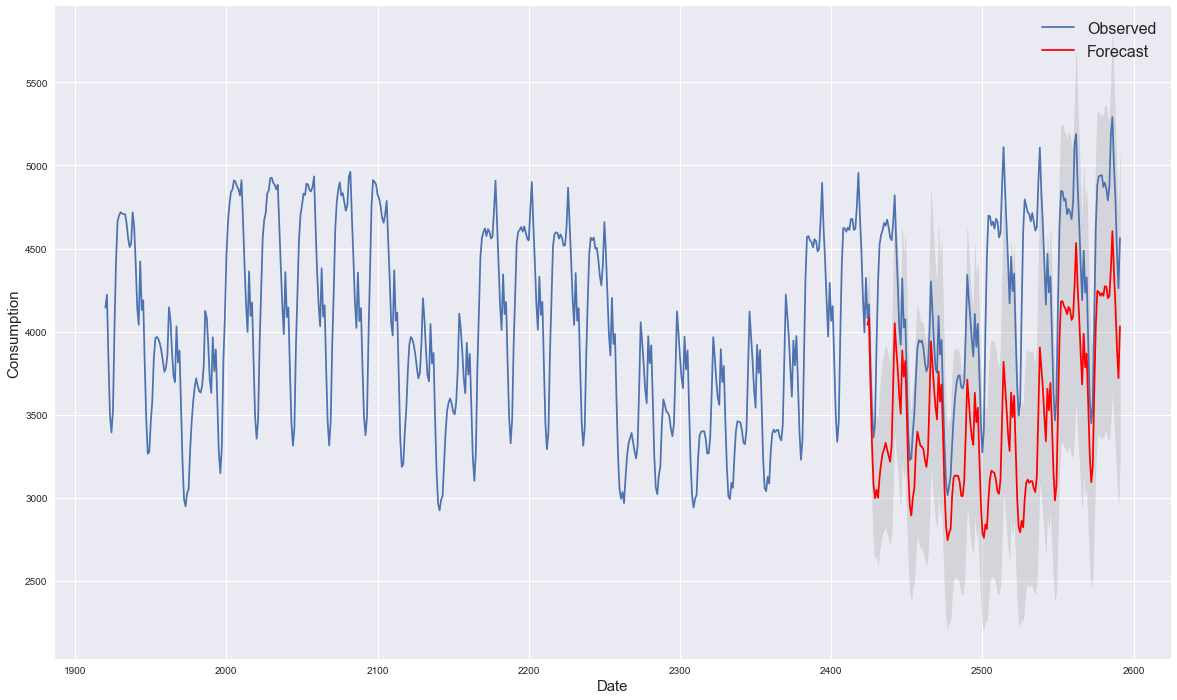

In [377]:
week_pred = np.sin(np.arange(length, length + 24*7) / (24*7))
month_pred = np.sin(np.arange(length, length + 24*7) / (24*30))

exogenous_pred = np.hstack([week_pred.reshape((24*7, 1)),
                                  month_pred.reshape(24*7, 1)])
pred_uc_4 = model.get_forecast(steps=24*7, exog=exogenous_pred)
pred_ci_4 = pred_uc_4.conf_int()

plt.figure(figsize=(20, 12))
plt.plot(np.arange(length-3*24*7, length+24*7), data['Consumption'][-4*24*7:]
         , label='Observed')
plt.plot(np.arange(length, length+24*7) , inverted_transform_2(pred_uc_4.predicted_mean), 
         color='red', label='Forecast')
plt.fill_between(pred_ci_4.index + length, 
                 inverted_transform_2(pred_ci_4.iloc[:, 0]), 
                 inverted_transform_2(pred_ci_4.iloc[:, 1]), color='gray', alpha=.2)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Consumption', fontsize=15)
plt.legend(fontsize=16)

plt.show()

Посмотрим на ошибку.

In [378]:
truth = data['Consumption'][-24*7:]
forecasts = inverted_transform_2(pred_uc_4.predicted_mean)
mse = ((forecasts - truth) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(round(mse, 2)))

Среднеквадратичная ошибка: 741049.09


Получилось хуже:( <br>
Но не сильно <br>
Может потом в пункте с) получится лучше? <br>
#### b)
Добавим значения температуры, используя на тестовом интервале времени истинные значения температуры <br>
Заметим, что мы предсказываем недельно продифференцированнный ряд, а он меньше по размеру чем исходный ряд и исходный ряд для температуры. Поэтому в качестве экзогенного фактора возьмем не саму температуру, а разность температур. (все равно после будем интегрировать)

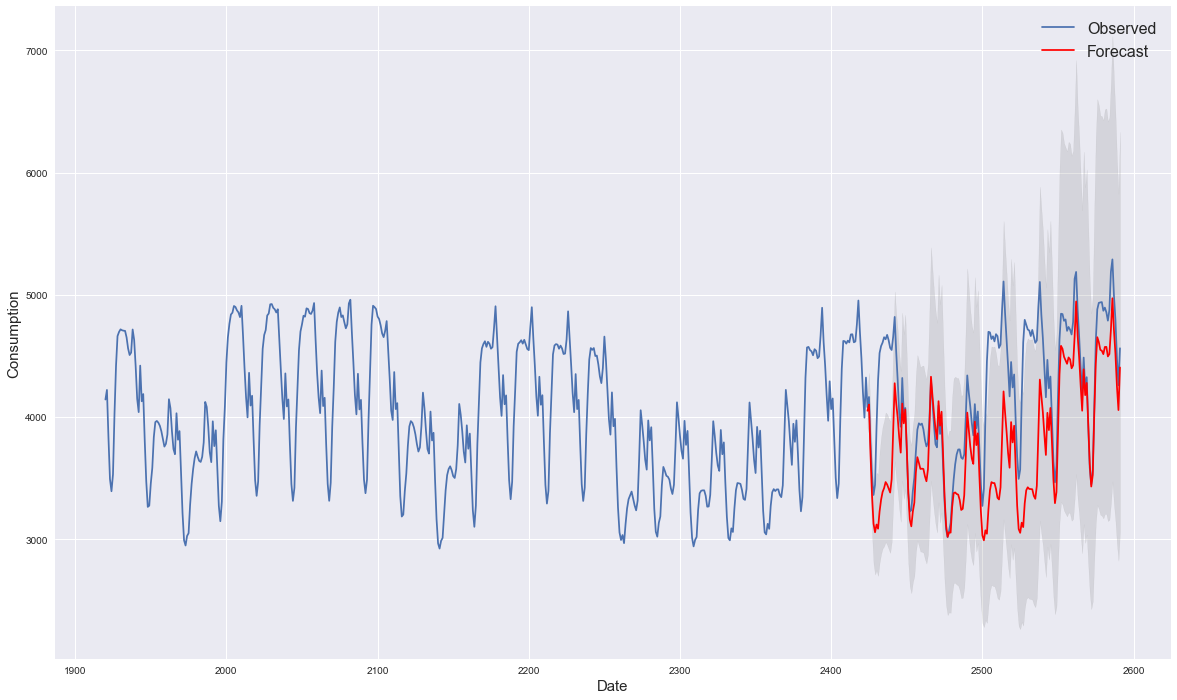

In [379]:
diff_temperature = np.array(data['Temperature'][7*24:]) - np.array(data['Temperature'][:-7*24])

model = sm.tsa.statespace.SARIMAX(train_consumption_stat_week, exog=diff_temperature[:-24*7], 
                                  order=best_params[0], seasonal_order=best_params[1], 
                                  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()

pred_uc_5 = model.get_forecast(steps=24*7, exog=diff_temperature[-24*7:].reshape(24*7, 1))
pred_ci_5 = pred_uc_5.conf_int()

plt.figure(figsize=(20, 12))
plt.plot(np.arange(length-3*24*7, length+24*7), data['Consumption'][-4*24*7:]
         , label='Observed')
plt.plot(np.arange(length, length+24*7) , inverted_transform_2(pred_uc_5.predicted_mean), 
         color='red', label='Forecast')
plt.fill_between(pred_ci_5.index + length, 
                 inverted_transform_2(pred_ci_5.iloc[:, 0]), 
                 inverted_transform_2(pred_ci_5.iloc[:, 1]), color='gray', alpha=.2)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Consumption', fontsize=15)
plt.legend(fontsize=16)

plt.show()

In [380]:
truth = data['Consumption'][-24*7:]
forecasts = inverted_transform_2(pred_uc_5.predicted_mean)
mse = ((forecasts - truth) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(round(mse, 2)))

Среднеквадратичная ошибка: 400293.31


Получилось значительно лучше, однако это нечестный способ. <br>
Попробуем на тестовом интервале температуру, которую предсказали ранее.

#### c)


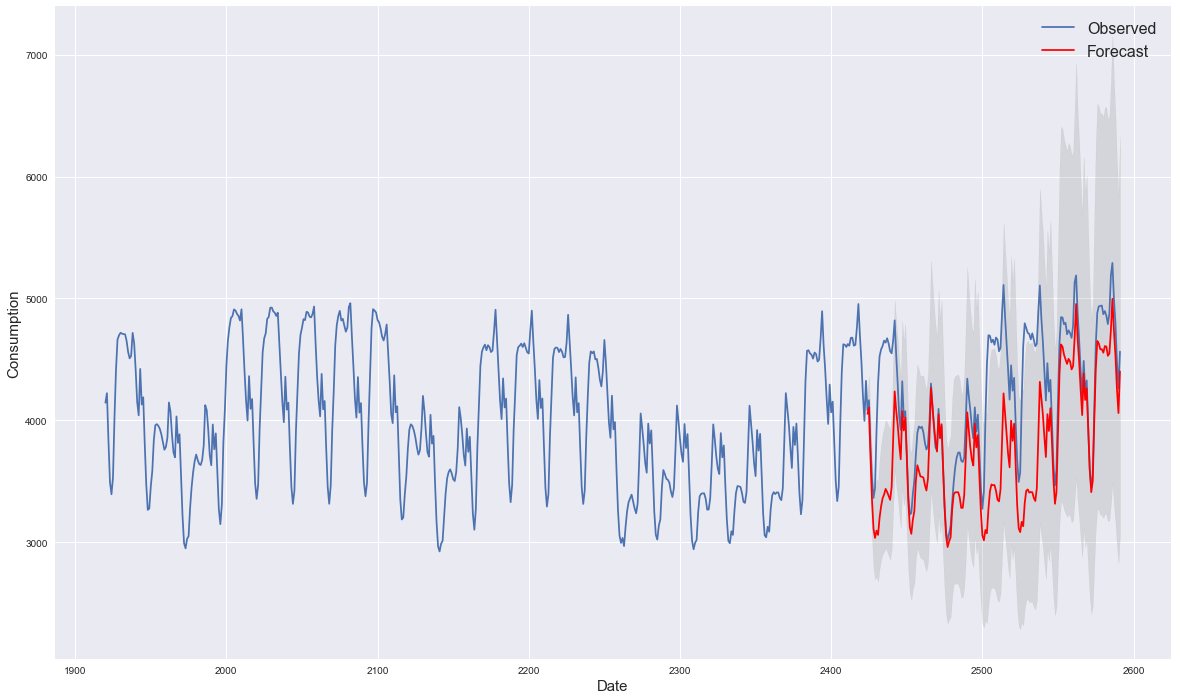

In [381]:
temperature_with_pred = np.append(np.array(data['Temperature'][:-24*7]), 
                                  boxcox_inverted(pred_uc.predicted_mean, lambd))
diff_temperature= temperature_with_pred[7*24:] - temperature_with_pred[:-7*24]


model = sm.tsa.statespace.SARIMAX(train_consumption_stat_week, exog=diff_temperature[:-24*7], 
                                  order=best_params[0], seasonal_order=best_params[1], 
                                  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()

pred_uc_6 = model.get_forecast(steps=24*7, exog=diff_temperature[-24*7:].reshape(24*7, 1))
pred_ci_6 = pred_uc_6.conf_int()

plt.figure(figsize=(20, 12))
plt.plot(np.arange(length-3*24*7, length+24*7), data['Consumption'][-4*24*7:]
         , label='Observed')
plt.plot(np.arange(length, length+24*7) , inverted_transform_2(pred_uc_6.predicted_mean), 
         color='red', label='Forecast')
plt.fill_between(pred_ci_6.index + length, 
                 inverted_transform_2(pred_ci_6.iloc[:, 0]), 
                 inverted_transform_2(pred_ci_6.iloc[:, 1]), color='gray', alpha=.2)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Consumption', fontsize=15)
plt.legend(fontsize=16)

plt.show()

In [382]:
truth = test_data['Consumption']
forecasts = inverted_transform_2(pred_uc_6.predicted_mean)
mse = ((forecasts - data['Consumption'][-24*7:]) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(round(mse, 2)))

Среднеквадратичная ошибка: 396603.13


Ого, еще меньше. Но разница совсем небольшая. 

#### d)
Теперь возьмем в качестве экзогенных факторов и недельную и месячную сезонности, и температуру

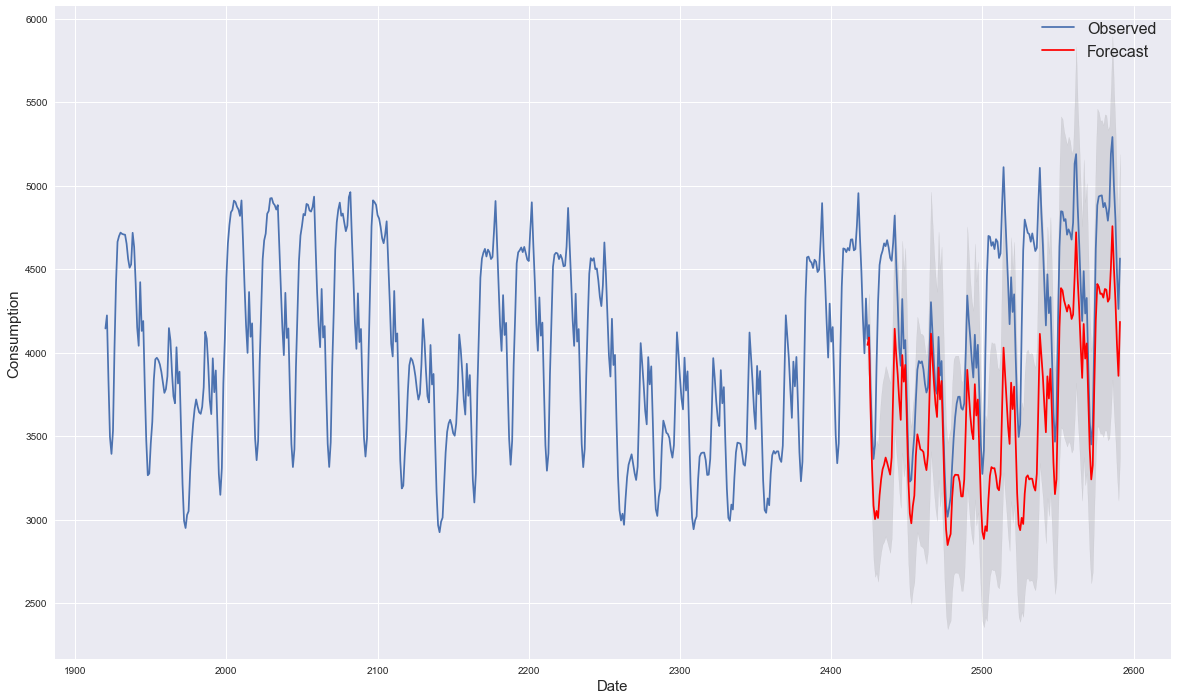

In [383]:
exogenous_regressors_temp = np.hstack((exogenous_regressors, diff_temperature[:-24*7].reshape(-1, 1)))
exogenous_pred_temp = np.hstack((exogenous_pred, diff_temperature[-24*7:].reshape(-1, 1)))

model = sm.tsa.statespace.SARIMAX(train_consumption_stat_week, exog=exogenous_regressors_temp, 
                                  order=best_params[0], seasonal_order=best_params[1], 
                                  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()

pred_uc_7 = model.get_forecast(steps=24*7, exog=exogenous_pred_temp)
pred_ci_7 = pred_uc_7.conf_int()

plt.figure(figsize=(20, 12))
plt.plot(np.arange(length-3*24*7, length+24*7), data['Consumption'][-4*24*7:]
         , label='Observed')
plt.plot(np.arange(length, length+24*7) , inverted_transform_2(pred_uc_7.predicted_mean), 
         color='red', label='Forecast')
plt.fill_between(pred_ci_7.index + length, 
                 inverted_transform_2(pred_ci_7.iloc[:, 0]), 
                 inverted_transform_2(pred_ci_7.iloc[:, 1]), color='gray', alpha=.2)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Consumption', fontsize=15)
plt.legend(fontsize=16)

plt.show()

In [384]:
truth = data['Consumption'][-24*7:]
forecasts = inverted_transform_2(pred_uc_7.predicted_mean)
mse = ((forecasts - truth) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(round(mse, 2)))

Среднеквадратичная ошибка: 558133.79


Самое лучшее предсказание получилось с учетом температуры (примерно одинаково на истинных тестовых данных и на предсказанных), но без учета недельной и месячной сезонности.

Рассмотрим вторую по aic модель, которую также рассматривали ранее, и проделаем для нее эти же пункты.

#### a)

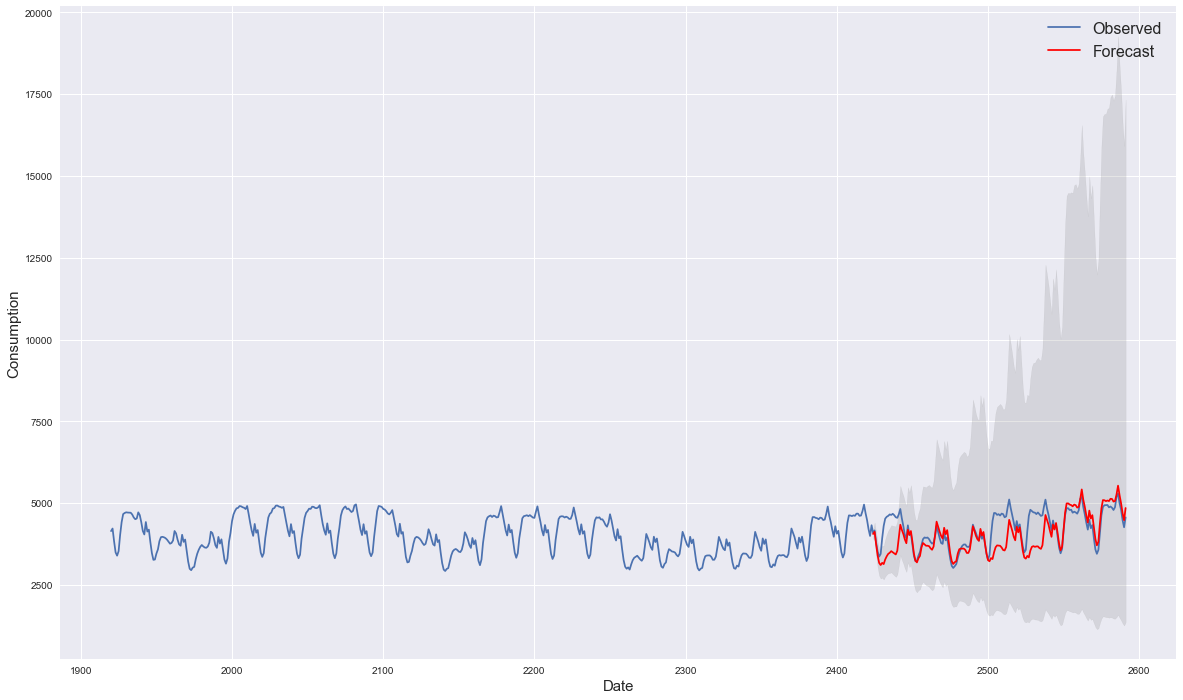

In [385]:
length = len(train_consumption_stat_week)
week_season = np.sin(np.arange(length) / (24*7))
month_season = np.sin(np.arange(length) / (24*30))
exogenous_regressors = np.hstack((week_season.reshape((length, 1)),
                                  month_season.reshape((length, 1))))
model = sm.tsa.statespace.SARIMAX(train_consumption_stat_week, exog=exogenous_regressors, 
                                  order=(2, 1, 1), seasonal_order=(1, 1, 1, 24), 
                                  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()
                                 
week_pred = np.sin(np.arange(length, length + 24*7) / (24*7))
month_pred = np.sin(np.arange(length, length + 24*7) / (24*30))

exogenous_pred = np.hstack([week_pred.reshape((24*7, 1)),
                                  month_pred.reshape(24*7, 1)])
pred_uc_4 = model.get_forecast(steps=24*7, exog=exogenous_pred)
pred_ci_4 = pred_uc_4.conf_int()

plt.figure(figsize=(20, 12))
plt.plot(np.arange(length-3*24*7, length+24*7), data['Consumption'][-4*24*7:]
         , label='Observed')
plt.plot(np.arange(length, length+24*7) , inverted_transform_2(pred_uc_4.predicted_mean), 
         color='red', label='Forecast')
plt.fill_between(pred_ci_4.index + length, 
                 inverted_transform_2(pred_ci_4.iloc[:, 0]), 
                 inverted_transform_2(pred_ci_4.iloc[:, 1]), color='gray', alpha=.2)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Consumption', fontsize=15)
plt.legend(fontsize=16)

plt.show()

In [386]:
truth = data['Consumption'][-24*7:]
forecasts = inverted_transform_2(pred_uc_4.predicted_mean)
mse = ((forecasts - truth) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(round(mse, 2)))

Среднеквадратичная ошибка: 264861.92


Ошибка получилась меньше, чем в предыдущей модели.

#### b)

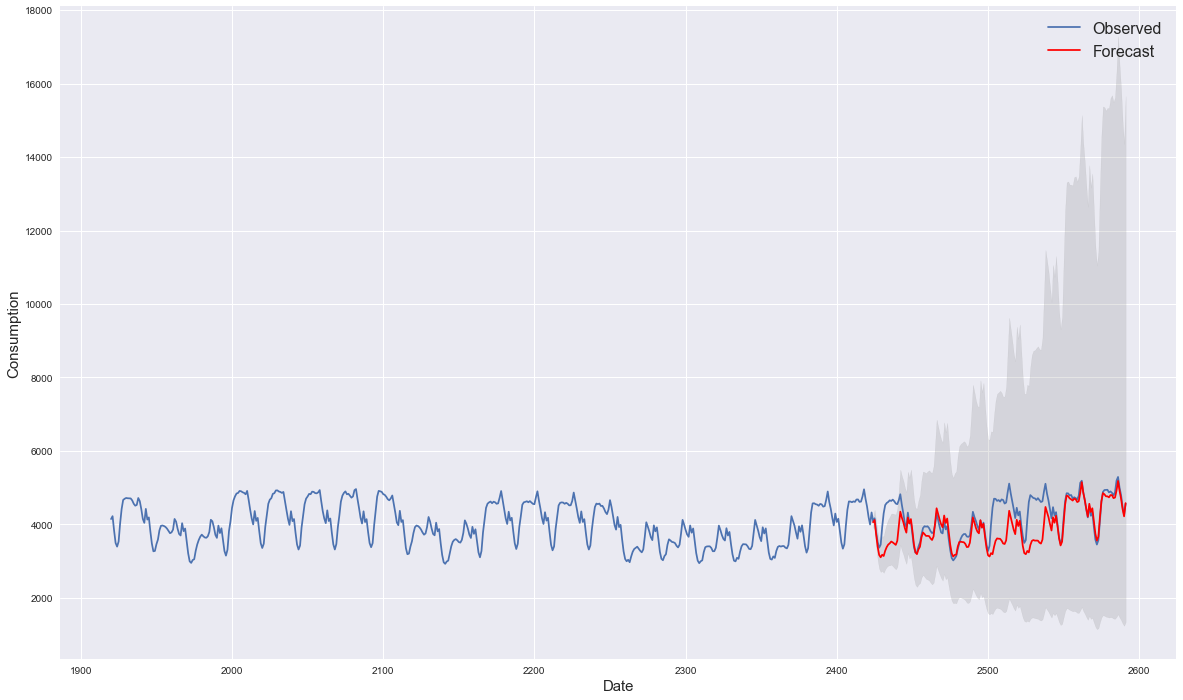

In [337]:
diff_temperature = np.array(data['Temperature'][7*24:]) - np.array(data['Temperature'][:-7*24])

model = sm.tsa.statespace.SARIMAX(train_consumption_stat_week, exog=diff_temperature[:-24*7], 
                                  order=(2, 1, 1), seasonal_order=(1, 1, 1, 24), 
                                  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()

pred_uc_5 = model.get_forecast(steps=24*7, exog=diff_temperature[-24*7:].reshape(24*7, 1))
pred_ci_5 = pred_uc_5.conf_int()

plt.figure(figsize=(20, 12))
plt.plot(np.arange(length-3*24*7, length+24*7), data['Consumption'][-4*24*7:]
         , label='Observed')
plt.plot(np.arange(length, length+24*7) , inverted_transform_2(pred_uc_5.predicted_mean), 
         color='red', label='Forecast')
plt.fill_between(pred_ci_5.index + length, 
                 inverted_transform_2(pred_ci_5.iloc[:, 0]), 
                 inverted_transform_2(pred_ci_5.iloc[:, 1]), color='gray', alpha=.2)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Consumption', fontsize=15)
plt.legend(fontsize=16)

plt.show()

In [338]:
truth = data['Consumption'][-24*7:]
forecasts = inverted_transform_2(pred_uc_5.predicted_mean)
mse = ((forecasts - truth) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(round(mse, 2)))

Среднеквадратичная ошибка: 299606.81


#### c)

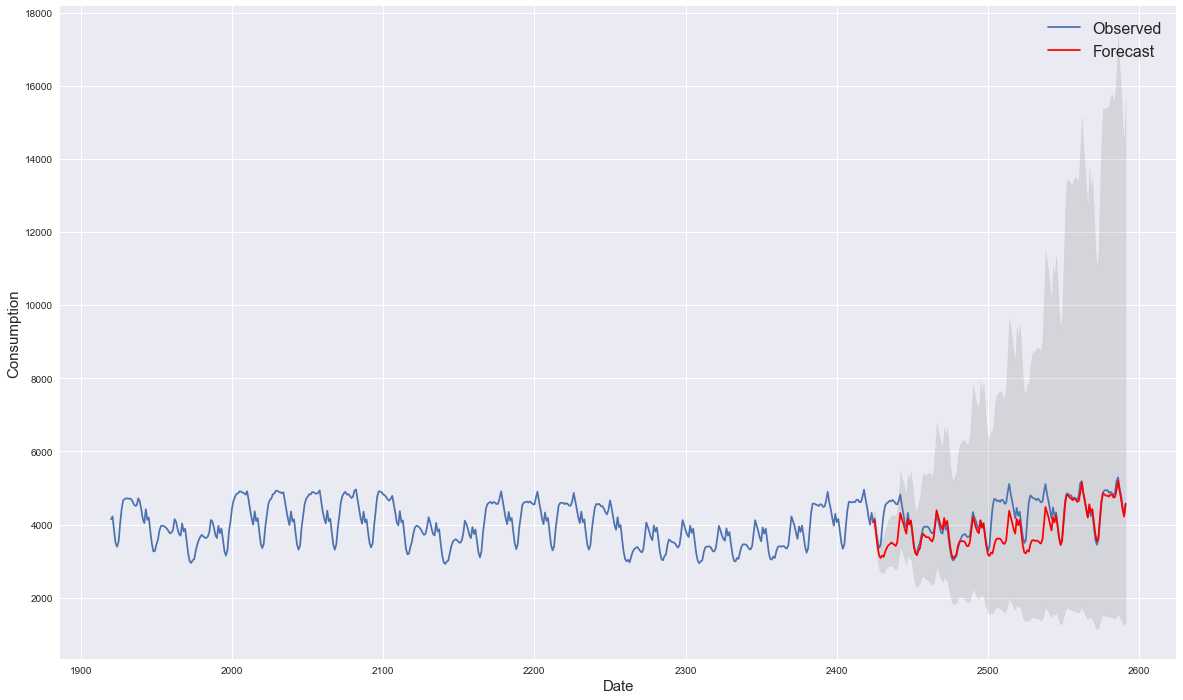

In [340]:
temperature_with_pred = np.append(np.array(data['Temperature'][:-24*7]), 
                                  boxcox_inverted(pred_uc.predicted_mean, lambd))
diff_temperature= temperature_with_pred[7*24:] - temperature_with_pred[:-7*24]


model = sm.tsa.statespace.SARIMAX(train_consumption_stat_week, exog=diff_temperature[:-24*7], 
                                  order=(2, 1, 1), seasonal_order=(1, 1, 1, 24), 
                                  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()

pred_uc_6 = model.get_forecast(steps=24*7, exog=diff_temperature[-24*7:].reshape(24*7, 1))
pred_ci_6 = pred_uc_6.conf_int()

plt.figure(figsize=(20, 12))
plt.plot(np.arange(length-3*24*7, length+24*7), data['Consumption'][-4*24*7:]
         , label='Observed')
plt.plot(np.arange(length, length+24*7) , inverted_transform_2(pred_uc_6.predicted_mean), 
         color='red', label='Forecast')
plt.fill_between(pred_ci_6.index + length, 
                 inverted_transform_2(pred_ci_6.iloc[:, 0]), 
                 inverted_transform_2(pred_ci_6.iloc[:, 1]), color='gray', alpha=.2)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Consumption', fontsize=15)
plt.legend(fontsize=16)

plt.show()

In [341]:
truth = test_data['Consumption']
forecasts = inverted_transform_2(pred_uc_6.predicted_mean)
mse = ((forecasts - data['Consumption'][-24*7:]) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(round(mse, 2)))

Среднеквадратичная ошибка: 297489.29


Как и в случае первой модели, ошибка в пунктах b) и c) получилась примерно одинаковой.

#### d)

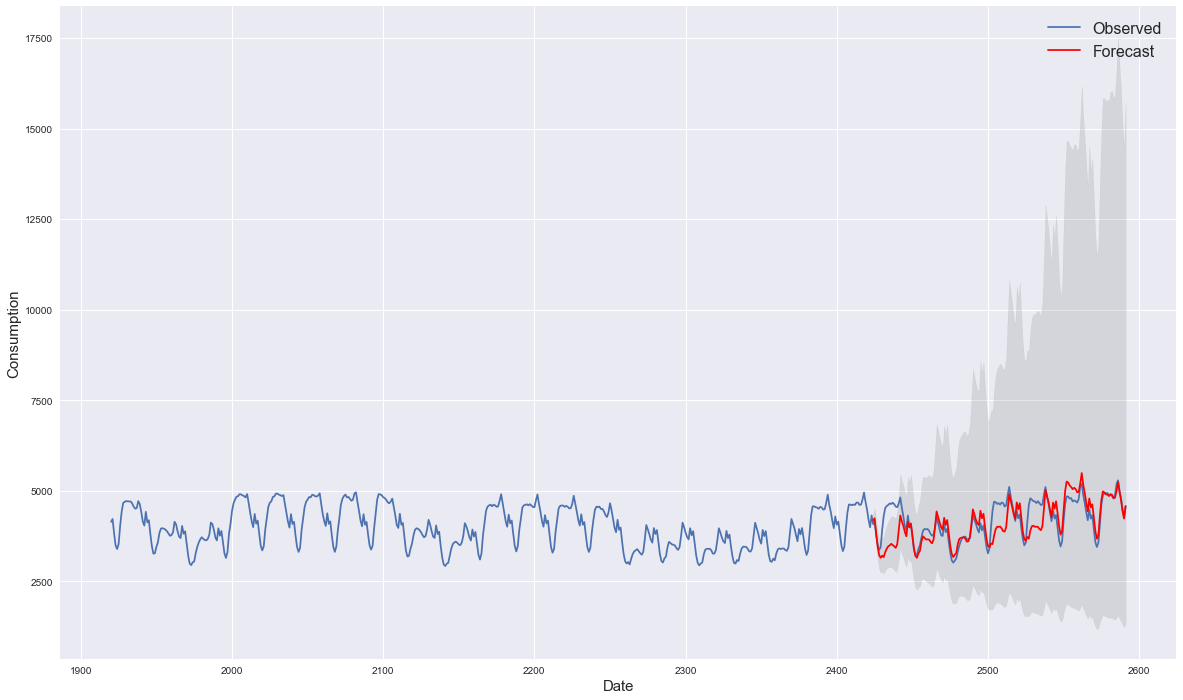

In [342]:
exogenous_regressors_temp = np.hstack((exogenous_regressors, diff_temperature[:-24*7].reshape(-1, 1)))
exogenous_pred_temp = np.hstack((exogenous_pred, diff_temperature[-24*7:].reshape(-1, 1)))

model = sm.tsa.statespace.SARIMAX(train_consumption_stat_week, exog=exogenous_regressors_temp, 
                                  order=(2, 1, 1), seasonal_order=(1, 1, 1, 24), 
                                  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()

pred_uc_7 = model.get_forecast(steps=24*7, exog=exogenous_pred_temp)
pred_ci_7 = pred_uc_7.conf_int()

plt.figure(figsize=(20, 12))
plt.plot(np.arange(length-3*24*7, length+24*7), data['Consumption'][-4*24*7:]
         , label='Observed')
plt.plot(np.arange(length, length+24*7) , inverted_transform_2(pred_uc_7.predicted_mean), 
         color='red', label='Forecast')
plt.fill_between(pred_ci_7.index + length, 
                 inverted_transform_2(pred_ci_7.iloc[:, 0]), 
                 inverted_transform_2(pred_ci_7.iloc[:, 1]), color='gray', alpha=.2)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Consumption', fontsize=15)
plt.legend(fontsize=16)

plt.show()

In [343]:
truth = data['Consumption'][-24*7:]
forecasts = inverted_transform_2(pred_uc_7.predicted_mean)
mse = ((forecasts - truth) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(round(mse, 2)))

Среднеквадратичная ошибка: 188088.22


В этой же модели наименьшая насреднеквадратичная ошибка получилась при учете недельной и месячной сезонностей и температуры. (Что больше похоже на правду)

Можно сделать вывод, что если нас интересуют сами предсказания, то выбранная модель по наименьшему критерию aic может не являться оптимальной. Это сказывается и на обычных предсказаниях, и на предсказаниях с экзогенными факторами.